# Music Recommender
- Author: Anthony Ayala, MSBA Class of 2024
- Date: 2/9/2024
- Course: Intro to Machine Learning
---
## Objective:
You've taken a job with your favorite music streaming srevice and they've asked you to come up with a way to make recommendations based on a **user's play count**. Your boss challenges you to build and compare two types of recommender systems (Singular Value Decomposition a.k.a SVD and K-Nearest Neighbor a.k.a KNN) using a subset of the Million Song Dataset.

## Getting the Data:
- You are provided with two files, the first file, “kaggle_visible_evaluation_triplets.txt”, contains user,
song, play counts. The second file “Unique_tracks.txt” contains details about the song (track, artist,
song). Both datasets are in different formats, I’ve provided you with a sample notebook to import
the files.

- Creating a Dataset of You and a Peer.
- Create a dataset of you and a peer’s favorite songs with a play count of 5 or 10. For example here
are 5 of my favorite songs
- Append this dataset to your user, song, playcount data.

## Preprocessing:
We are going to use the play count column as a surrogate for an explicit rating, play counts range
from 1 to 923. My recommendation is to BIN the data so it’s either 1 – 5 or 1 through 10 but that’s
up to you. Our assumption is that if someone listened to a song only once then they didn’t love it
but if they listened to something say 5 or more times, they probably enjoyed it.

- Merge the two datasets together to simplify your analysis.

## Exploratory Data Analysis:
- Do some basic analysis of the users. What users listen the most, how many play counts, how many unique songs etc. make some charts and tables to support your anlaysis.
- Do some basic analysis of the artists and songs. What are the most popular songs and artists, how
many unique users have listened to them?

## Train & Evaluate Recommenders
1. Create a baseline recommendation, see BaselineOnly() method of surprise.
2. Next train a SVD, document the hyperparameters chosen.
>  Did you do any hyper parameter tuning?
3. Compare the BaselineI() performance to that of the SVD. Even if Baseline() RMSE/MAE is lower than the SVD
why would having a SVD be preferable to a baseline only model?
- Document performance RMSE/MAE
- Document any hyper parameter tuning you’ve performed.

### Answer the following:
1. For a random sample of 5 users with 10 or more song plays make 5 recommendations of
songs they have not listened to with your SVD.
2. Recommendation systems should provide “relevant” recommendations expanding the user’s
pool of options (songs in our case) what would you do to improve your recommendation to
expand a user’s relevant song recommendation pool?
3. What are your top 10 recommendations for a net new user? That is a user with no
user/song play count? essentially the cold start problem.
4. What are your top 10 recommendations for you and your peer?
a. Do the recommendations make sense? What could you do to improve them? Do you
think an Item based KNN might better?


In [1]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3162659 sha256=b65e6b8052e387d74ae1fb1347e26b6c1c8bdc9fd521f561e4f9ee0438b9c8a1
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# -- suprise stuff --
from surprise import Dataset, SVD, KNNBasic
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split

from surprise import Dataset, Reader, BaselineOnly, accuracy
from surprise.model_selection import train_test_split
import pandas as pd
from surprise import accuracy

## Upload Data

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
column_names = ['user_id', 'song_id', 'play_count']
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Ames Projects Python and SQL/kaggle_visible_evaluation_triplets.txt", sep='\t', names=column_names)
print(df.shape)
#df = df.sample(10000)
df.head()

(1450933, 3)


,user_id,song_id,play_count
0,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOBONKR12A58A7A7E0,1
1,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOEGIYH12A6D4FC0E3,1
2,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOFLJQZ12A6D4FADA6,1
3,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOHTKMO12AB01843B0,1
4,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SODQZCY12A6D4F9D11,1


In [6]:
# Data Info
print(df.info())
print('Rows and Columns:', df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1450933 entries, 0 to 1450932
Data columns (total 3 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   user_id     1450933 non-null  object
 1   song_id     1450933 non-null  object
 2   play_count  1450933 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 33.2+ MB
None
Rows and Columns: (1450933, 3)


10,000 Rows and 3 Columns

In [7]:
# Descriptive Statistics and Play Count Column
print("Descriptive Statistics of Play Counts")
print(df.describe().round(2),'\n')
print("Top 10 Value Counts of Play Counts:")
print(df['play_count'].value_counts().nlargest(10), '\n')
print("Number of Unique Play Counts:", df['play_count'].nunique())

Descriptive Statistics of Play Counts
       play_count
count  1450933.00
mean         3.19
std          7.05
min          1.00
25%          1.00
50%          1.00
75%          3.00
max        923.00 

Top 10 Value Counts of Play Counts:
1     839136
2     213712
3      95726
5      73542
4      55158
6      31902
7      22317
8      16179
10     15369
9      12227
Name: play_count, dtype: int64 

Number of Unique Play Counts: 299


### Create your own music list
- I will take a look at the unique tracks text file and take a look at a name of songs and bands that I would usually listen to, and see if the music I like is in the list. If the music I like isn't in the list, then I will work with what I got and see expand my music taste and be excited to be recommended other works of art.


In [8]:
column_names = ['track_id', 'song_id', 'song_artist', 'song_name']
unique_tracks = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Ames Projects Python and SQL/unique_tracks.txt", sep='<SEP>', names=column_names)
unique_tracks.head()

<ipython-input-8-f2044a4e865c>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  unique_tracks = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Ames Projects Python and SQL/unique_tracks.txt", sep='<SEP>', names=column_names)


,track_id,song_id,song_artist,song_name
0,TRMMMYQ128F932D901,SOQMMHC12AB0180CB8,Faster Pussy cat,Silent Night
1,TRMMMKD128F425225D,SOVFVAK12A8C1350D9,Karkkiautomaatti,Tanssi vaan
2,TRMMMRX128F93187D9,SOGTUKN12AB017F4F1,Hudson Mohawke,No One Could Ever
3,TRMMMCH128F425532C,SOBNYVR12A8C13558C,Yerba Brava,Si Vos Querés
4,TRMMMWA128F426B589,SOHSBXH12A8C13B0DF,Der Mystic,Tangle Of Aspens


In [9]:
# EDA of Unique Tracks DF
print(f"No. of unique artists: {unique_tracks['song_artist'].nunique()}")
print(f"No. of unique songs: {unique_tracks['song_name'].nunique()}")
print('\n')
#------------------------------------------------------------------------------
print('Top 25 Artist Appearances:')
print(unique_tracks['song_artist'].value_counts().nlargest(25))
#------------------------------------------------------------------------------
print('\n')
print('Top 25 Song Appearances:')
print(unique_tracks['song_name'].value_counts().nlargest(25))
print('\n')
#------------------------------------------------------------------------------
print('Bottom 25 Artist Appearances:')
print(unique_tracks['song_artist'].value_counts().nsmallest(25))
#------------------------------------------------------------------------------

No. of unique artists: 72665
No. of unique songs: 702000


Top 25 Artist Appearances:
Michael Jackson       194
Johnny Cash           193
Beastie Boys          187
Joan Baez             181
Neil Diamond          176
Duran Duran           175
Radiohead             173
Franz Ferdinand       173
Aerosmith             173
The Rolling Stones    171
The Doors             171
Jimi Hendrix          170
The Cure              169
Ella Fitzgerald       168
Faron Young           168
Elvis Presley         167
Kenny Rogers          167
Sonny Rollins         166
Willie Nelson         165
Venom                 164
Bob Dylan             163
Petra                 161
Frank Sinatra         161
Ray Charles           160
Joe Satriani          159
Name: song_artist, dtype: int64


Top 25 Song Appearances:
Intro              1511
Untitled            414
Outro               350
Interlude           298
Home                237
Silent Night        221
Time                210
Hold On             203
Tonight      

### Query for Songs and Pick out What you Like
- Based on the Top and Bottom List. What artists I have found that I am a fan of are Michael Jackson, Aerosmith, The Rolling Stones, and the Lil Wayne song is either "Tie My Hands", "Pretty Lil' Heart", or "Shooter".

In [12]:
# Query 20 Michael Jackson Songs and make it random
#np.random.seed(0) # use this code to get the same set of songs every time
unique_tracks.query("song_artist == 'Michael Jackson'").sample(10)

,track_id,song_id,song_artist,song_name
281660,TRFQIOB128F92F375F,SOAKCNU12A8C135445,Michael Jackson,Gone Too Soon
66645,TRWJKVP128F92DCA7E,SOLISQK12A8C1416AF,Michael Jackson,Billie Jean
18013,TRMNWJW128F428364D,SOKIOOC12AF729ED9E,Michael Jackson,In The Closet
988056,TRYEOWZ128F92CBBC9,SOWXIKR12AF72A587E,Michael Jackson,The Way You Make Me Feel
711001,TRJNARS128E07847AE,SOFQCLR12A6701D99D,Michael Jackson,You Are There
111763,TRGXVEN128F42AD5EA,SOUGPGW12A8C13E5C2,Michael Jackson,Shake Your Body (Down To The Ground)
554932,TRTITDG128F42132F4,SOROJTQ12A6D4F9F89,Michael Jackson,You Can't Win
157377,TRCGURD128F9342AD2,SOTLHDK12AB018A405,Michael Jackson,"Happy (Love Theme From ""Lady Sings The Blues"")"
450633,TRAJZIS128F4288E43,SOQGFVA12A8C13AE87,Michael Jackson,We're Almost There
976401,TRYZOSX128F92EE1F4,SOBKDCU12A6D4F80F6,Michael Jackson,Girl You're So Together


In [18]:
my_song_list = ['Rock With You', 'Man In The Mirror',  'P.Y.T. (Pretty Young Thing)', 'You Are Not Alone']

The songs I will pick from MJ is "Rock With You", "Man In The Mirror", "P.Y.T (Pretty Young Thing)", and "You Are Not Alone".
- I have chosen 4 songs so far and there are six more songs to choose

In [14]:
unique_tracks.query("song_artist == 'Aerosmith'").sample(10)

,track_id,song_id,song_artist,song_name
372399,TRZEPFA128F4280390,SOTJWWE12AF72A5FCB,Aerosmith,The Grind
416275,TRIDZST128E079433E,SOHZCHN12AF729F303,Aerosmith,Dude (Looks Like A Lady)
180721,TRCJFZB128F42634A6,SOSHFWT12A8C134880,Aerosmith,Just Push Play
656821,TREWLKP128E078ED1F,SOIIPYT12CF5F888DB,Aerosmith,Cryin'
79134,TRGWPRV128E078ECFF,SODYCHG12AB01847A6,Aerosmith,Dulcimer Stomp/ The Other Side
266898,TRBKUZI128F426BD3B,SOCEQNC12CF5CFD64B,Aerosmith,Three Mile Smile
462082,TRAYKOC128F930D2B8,SOMUMTW12A6701C7B8,Aerosmith,Cryin'
56352,TRWAKEO128F9334665,SOOGGAC12AB0189FB9,Aerosmith,Back In The Saddle
255422,TRBLSVS128F428038D,SOITJMH12CF5CFD681,Aerosmith,Never Loved A Girl
949508,TRKEDNT128E0794349,SOMLSHR12A6701DEDF,Aerosmith,The Other Side


In [19]:
# Create an aerosmith songs list
aerosmith_songs = ["Cryin'", "I Don't Want To Miss A Thing"]
# Extend aerosmith songs to original song list
my_song_list.extend(aerosmith_songs)

# Print the list
print('Updated song list: ' , my_song_list)

Updated song list:  ['Rock With You', 'Man In The Mirror', 'P.Y.T. (Pretty Young Thing)', 'You Are Not Alone', "Cryin'", "I Don't Want To Miss A Thing"]


The songs I will pick from Aerosmith is "Cryin'" and "I Don't Want To Miss A Thing"
- I have chosen 6 songs so far and there are 4 more songs to choose

---
Let's try to find artists and songs with the str.contains function as I don't want my list to be necessarily biased by just selecting the most popular artists/groups
- I also want to show that my music taste is more than just 80's and 90's music
- I want to see songs by Lauryn Hill, T-Pain, Drake and DMX. So let's pick a song from each of these artists


In [20]:
# Lil Wayne
unique_tracks.query("song_artist.str.lower() == 'lil wayne'").sample(n=10)

,track_id,song_id,song_artist,song_name
851348,TROHBZH128F422C0C5,SOIYRNI12AF72A43C2,Lil Wayne,I Miss My Dawgs
859699,TROQKUY12903CC6E14,SOPVKFD12AB018CB0F,Lil Wayne,Da Da Da
360881,TRZZSQU128F92FCDE8,SOXAYEX12AF72A6225,Lil Wayne,Hit Em Up
190952,TRCYCQW128F4274A27,SOMIKGL12A3F1EC9C8,Lil Wayne,3 Peat
498022,TRNKCPJ128F932B782,SOKSMFK12AB01876EB,Lil Wayne,Fly In
909932,TRXLYHD128F1499FC0,SOQRTSI12A8C140F95,Lil Wayne,Up To Me
477825,TRNINHO12903CC5C63,SOGFUHX12AB0189774,Lil Wayne,Get A Life
286704,TRFASZI128F93229B7,SOYFLSE12D021936ED,Lil Wayne,A Milli
241049,TRBFWYX128F145F889,SOIFTHQ12AF72A4829,Lil Wayne,Fly Talkin'
360375,TRZZIUD128F423C072,SOQRSAE12D02193DF9,Lil Wayne,Get Off The Corner


In [21]:
# Let's look for some artists that I hope to find in this list
unique_tracks.query("song_name.str.lower() == 'a milli'" )

,track_id,song_id,song_artist,song_name
286704,TRFASZI128F93229B7,SOYFLSE12D021936ED,Lil Wayne,A Milli
838664,TRDVEYF128F92F4A4C,SOQYLFQ12D02194D46,Lil Wayne,A Milli


In [22]:
# Append A Milli to the list
my_song_list.append('A Milli')
print('Updated song list: ' , my_song_list)

Updated song list:  ['Rock With You', 'Man In The Mirror', 'P.Y.T. (Pretty Young Thing)', 'You Are Not Alone', "Cryin'", "I Don't Want To Miss A Thing", 'A Milli']


In [23]:
# DMX
unique_tracks.query("song_artist.str.lower() == 'dmx'").sample(n=10)

,track_id,song_id,song_artist,song_name
480215,TRNNCBW128E078602D,SOKKAEC12A8C1437D4,DMX,Make A Move
105968,TRGSDWQ128F934B62E,SOOZNHM12AB0189430,DMX,It's All Good
877451,TRODWGG128F424077A,SOTXRAK12A8C13682D,DMX,What Happened 2 Forever
235557,TRBHZYO128E07862BE,SOGPEMQ12A67020412,DMX,Look Thru My Eyes
666276,TREQWXC128E0786048,SONIWIC12AB0181299,DMX,The Prayer V
763402,TRSDKMM128F425C02A,SORECCT12A6701DA29,DMX,Slippin'
967690,TRYHYRP128F421499F,SOSUIAK12AB01850CB,DMX,The Rain
479719,TRNADZF128F421499A,SOPDYHG12A6701D9EB,DMX,Ruff Radio 2 (Skit)
686957,TREDKHK128F4240796,SOWGVGY12A58A7BC30,DMX,Shadows Of Love
429543,TRACFAP128E07862C1,SOVQWEN12A8C141BD9,DMX,Damien


In [24]:
# Check if the data has ruff ryders anthem
unique_tracks.query("song_name.str.lower() == 'ruff ryders anthem'")

,track_id,song_id,song_artist,song_name
28381,TRMSGKF128E07862CC,SOFTFOR12A67020DB3,DMX,Ruff Ryders Anthem
108921,TRGDOTZ128F148CB9A,SOPYZFP12A58A7EA40,DJ Clue / DMX / Jadakiss / Styles / Eve / Drag-On,Ruff Ryders Anthem


In [25]:
# Append Ruff Ryders Anthem
my_song_list.append('Ruff Ryders Anthem')
print('Updated song list: ' , my_song_list)
print("Number of songs in the list:", len(my_song_list))

Updated song list:  ['Rock With You', 'Man In The Mirror', 'P.Y.T. (Pretty Young Thing)', 'You Are Not Alone', "Cryin'", "I Don't Want To Miss A Thing", 'A Milli', 'Ruff Ryders Anthem']
Number of songs in the list: 8


In [26]:
# T-Pain
unique_tracks.query("song_artist.str.lower() == 't-pain'")

,track_id,song_id,song_artist,song_name
49384,TRWFRRE128F42AFE40,SOWYIVN12D0219BA2E,T-Pain,Ur Not The Same Featuring Akon
62839,TRWLZMH128F92C22A0,SOZXERR12D021B5644,T-Pain,Reggae Night
88390,TRGFOMQ128F42AE35F,SOZVUPE12A8C13E9E8,T-Pain,Studio Luv
171468,TRCNWWC128F92C228F,SOFHNVU12D021994D0,T-Pain,I Got It
231899,TRBMDNN128F92ED75E,SOLEZCG12D02199550,T-Pain,Take A Ride Skit
236393,TRBHXMH128F42AE36F,SOONJIV12D021B3DA0,T-Pain,Ur Not The Same Featuring Akon
239253,TRBRDZB128F92C24D9,SODVIDG12D02199756,T-Pain,Let The Bass Drop
243561,TRBQVSQ128F42AFE34,SONAGHR12D0219AD6A,T-Pain,Rappa Ternt Sanga (Intro)
246791,TRBIKAA128F42AEAED,SORRTVA12D0219AA06,T-Pain,I'm Sprung
278915,TRFBTOE128F42AE370,SOKSJUI12D02199243,T-Pain,My Place


In [27]:
# Append I'm Sprung
my_song_list.append("I'm Sprung")
print('Updated song list: ' , my_song_list)
print("Number of songs in the list:", len(my_song_list))

Updated song list:  ['Rock With You', 'Man In The Mirror', 'P.Y.T. (Pretty Young Thing)', 'You Are Not Alone', "Cryin'", "I Don't Want To Miss A Thing", 'A Milli', 'Ruff Ryders Anthem', "I'm Sprung"]
Number of songs in the list: 9


In [28]:
# Lauyrn Hill
unique_tracks.query("song_artist.str.lower() == 'lauryn hill'").sample(n=10)

,track_id,song_id,song_artist,song_name
502189,TRPMKPI128F935055C,SOTNYDP12A5C5D4228,Lauryn Hill,Superstar
416945,TRIDDQX128F9350562,SOYEDNN12A58A788F1,Lauryn Hill,Every Ghetto_ Every City
626475,TRLFQOC128F426F272,SOJDPHC12AF72A8FD0,Lauryn Hill,War In The Mind
532372,TRPDBJG128F426F271,SOZFJHL12AF72A5C5A,Lauryn Hill,Interlude 2
292584,TRFUJVJ128F426F2A2,SOONCPO12AF72A1986,Lauryn Hill,Interlude 5
281799,TRFQNSS128F426F2AD,SODZBLX12A8C132E15,Lauryn Hill,So Much Things To Say
921200,TRXKEKK128F93278EC,SORMCTP12AB018024C,Lauryn Hill,Forgive Them Father
992595,TRYVYKU128F426F26F,SOPPUBI12B0B80C00C,Lauryn Hill,Interlude 1
475431,TRNQKAL128F93278E9,SOOWBOG12AB017BD2C,Lauryn Hill,Final Hour
104382,TRGJSAL128F92DDC1A,SOHGNHZ12D02197924,Lauryn Hill,Doo Wop (That Thing)


In [29]:
# Append Tell Him
my_song_list.append("Tell Him")
print('Updated song list: ' , my_song_list)
print("Number of songs in the list:", len(my_song_list))

Updated song list:  ['Rock With You', 'Man In The Mirror', 'P.Y.T. (Pretty Young Thing)', 'You Are Not Alone', "Cryin'", "I Don't Want To Miss A Thing", 'A Milli', 'Ruff Ryders Anthem', "I'm Sprung", 'Tell Him']
Number of songs in the list: 10


## Creating my own dataframe
- Since, I created a list I can then easily use the isin function to create the filtered dataframe
> What I will have to keep in mind is that there are going to be multiple song names and I will have to filter by artist

In [30]:
# Create a list of artists of interest
artists = ['Aerosmith', 'Michael Jackson', 'DMX', 'Lauryn Hill', 'T-Pain', 'Lil Wayne']
my_songs_df = unique_tracks[unique_tracks['song_name'].isin(my_song_list)]
my_songs_df = my_songs_df[my_songs_df['song_artist'].isin(artists)]

# drop duplicate song names
my_songs_df = my_songs_df.drop_duplicates(subset=['song_name'])

#show dataframe
my_songs_df

,track_id,song_id,song_artist,song_name
427,TRMMFIS128E078EDEA,SOYURIX12A6701E960,Aerosmith,Cryin'
28381,TRMSGKF128E07862CC,SOFTFOR12A67020DB3,DMX,Ruff Ryders Anthem
88433,TRGFXNI128F9350567,SOCYCKL12A58A79B1B,Lauryn Hill,Tell Him
102647,TRGETEF128F4262DD0,SOXVVHB12CF54662D9,Michael Jackson,Man In The Mirror
207290,TRRIRCF128F426A606,SOFRVOH12A8C132F50,Michael Jackson,You Are Not Alone
245494,TRBIGLJ12903CBAC47,SOXYSIC12CF5827361,Michael Jackson,Rock With You
246791,TRBIKAA128F42AEAED,SORRTVA12D0219AA06,T-Pain,I'm Sprung
286704,TRFASZI128F93229B7,SOYFLSE12D021936ED,Lil Wayne,A Milli
293293,TRFLCLG128F425FD9B,SOXIDFH12CF5CFD5B9,Michael Jackson,P.Y.T. (Pretty Young Thing)
328203,TRQPEVG128F427A4D0,SOARVJQ12CF5F87C41,Aerosmith,I Don't Want To Miss A Thing


### My Song Dataframe
- Let's edit this dataframe where I add my own user_id and add my own playcount to each song

In [31]:
# make all values in track_id column null
my_songs_df['track_id'] = None

# fill in the null values with my user id
my_songs_df['track_id'].fillna('Anthony Ayala', inplace=True)

# Rename the track id column to user_id
my_songs_df.rename(columns={'track_id': 'user_id'}, inplace=True)

# create a new column called play_count and add 10 to each row
my_songs_df['play_count'] = 10

# reset the index
my_songs_df.reset_index(inplace=True)

# Drop index
my_songs_df.drop(columns=['index', 'song_name', 'song_artist'], inplace=True)

# Show the updated data frame
my_songs_df

,user_id,song_id,play_count
0,Anthony Ayala,SOYURIX12A6701E960,10
1,Anthony Ayala,SOFTFOR12A67020DB3,10
2,Anthony Ayala,SOCYCKL12A58A79B1B,10
3,Anthony Ayala,SOXVVHB12CF54662D9,10
4,Anthony Ayala,SOFRVOH12A8C132F50,10
5,Anthony Ayala,SOXYSIC12CF5827361,10
6,Anthony Ayala,SORRTVA12D0219AA06,10
7,Anthony Ayala,SOYFLSE12D021936ED,10
8,Anthony Ayala,SOXIDFH12CF5CFD5B9,10
9,Anthony Ayala,SOARVJQ12CF5F87C41,10


In [32]:
# Create a csv file for my friends to download
my_songs_df.to_csv("anthony ayala's ten songs.csv")

### Concatenate my friends's songs to my songs data frame

In [33]:
# read friend's csv file
erics_df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Ames Projects Python and SQL/erics_songs.xlsx')

In [34]:
bestfriend_songs_df = pd.concat([my_songs_df,erics_df],axis=0)
bestfriend_songs_df

,user_id,song_id,play_count
0,Anthony Ayala,SOYURIX12A6701E960,10
1,Anthony Ayala,SOFTFOR12A67020DB3,10
2,Anthony Ayala,SOCYCKL12A58A79B1B,10
3,Anthony Ayala,SOXVVHB12CF54662D9,10
4,Anthony Ayala,SOFRVOH12A8C132F50,10
5,Anthony Ayala,SOXYSIC12CF5827361,10
6,Anthony Ayala,SORRTVA12D0219AA06,10
7,Anthony Ayala,SOYFLSE12D021936ED,10
8,Anthony Ayala,SOXIDFH12CF5CFD5B9,10
9,Anthony Ayala,SOARVJQ12CF5F87C41,10


### Concatenate our dataframe to the kaggle dataframe

In [36]:
songs_df = pd.concat([bestfriend_songs_df,df],axis=0)

In [37]:
# info and shape of dataframe
print(songs_df.info())
print("Number of rows and columns:" , songs_df.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450952 entries, 0 to 1450932
Data columns (total 3 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   user_id     1450952 non-null  object
 1   song_id     1450952 non-null  object
 2   play_count  1450952 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 44.3+ MB
None
Number of rows and columns: (1450952, 3)


In [38]:
# Top 10 Most Common Play Counts
songs_df['play_count'].value_counts().nlargest(10)

1     839136
2     213712
3      95726
5      73542
4      55158
6      31902
7      22317
8      16179
10     15388
9      12227
Name: play_count, dtype: int64

---
## Preprocessing dataframe
- Lots of 1's, 2's and 3's, we saw in the previous code but let's preprocess the data so that we only get play counts from 0 to 10. The purpose of this is so that when we make our predictions/recommendations the model can understand how to make recommednations based on the idea of binning. For example, if a song is only listened to once then the user didn't love it but if they listened to something more than 5 or more times, then they probably enjoyed it.

In [39]:
# Define bins and labels
bins = [1, 2, 3, 4, 5,6,7,8,9,10, float('inf')]
labels = [1, 2, 3, 4, 5,6,7,8,9,10]

# Bin the 'play_count' column
songs_df['play_count_binned'] = pd.cut(songs_df['play_count'], bins=bins, labels=labels, right=False)
songs_df['play_count_binned'].value_counts()

1     839136
2     213712
3      95726
10     91053
5      73542
4      55158
6      31902
7      22317
8      16179
9      12227
Name: play_count_binned, dtype: int64

In [40]:
print(f"No. of unique users: {songs_df['user_id'].nunique()}")
print(f"No. of unique songs: {songs_df['song_id'].nunique()}")
print(f"No. of unique play counts: {songs_df['play_count'].nunique()}")

No. of unique users: 110002
No. of unique songs: 163220
No. of unique play counts: 299


### Merge the songs_df to unique_tracks df

In [41]:
# Merging triplets.txt and unique_tracks.txt dataset

merged_df = pd.merge(songs_df, unique_tracks.drop_duplicates(['song_id']), how='left', on='song_id')
merged_df.head()

,user_id,song_id,play_count,play_count_binned,track_id,song_artist,song_name
0,Anthony Ayala,SOYURIX12A6701E960,10,10,TRMMFIS128E078EDEA,Aerosmith,Cryin'
1,Anthony Ayala,SOFTFOR12A67020DB3,10,10,TRMSGKF128E07862CC,DMX,Ruff Ryders Anthem
2,Anthony Ayala,SOCYCKL12A58A79B1B,10,10,TRGFXNI128F9350567,Lauryn Hill,Tell Him
3,Anthony Ayala,SOXVVHB12CF54662D9,10,10,TRGETEF128F4262DD0,Michael Jackson,Man In The Mirror
4,Anthony Ayala,SOFRVOH12A8C132F50,10,10,TRRIRCF128F426A606,Michael Jackson,You Are Not Alone


In [42]:
# Take a look at Eric's Songs
merged_df.query("user_id.str.lower() == 'eric m'")

,user_id,song_id,play_count,play_count_binned,track_id,song_artist,song_name
10,ERIC M,SONLSKL12A8C13CF26,10,10,TRICZCQ128F429EC43,Paramore,Misery Business (Album Version)
11,ERIC M,SOLVQGA12A8C1399CA,10,10,TRQFEDD128F9340645,Paramore,crushcrushcrush (Album Version)
12,ERIC M,SOEYVHS12AB0181D31,10,10,TRQUJJJ128F93450B9,Lady GaGa,Monster
13,ERIC M,SOJJLNE12A8C13E5C3,10,10,TRMSSOX128F42B84FB,Beyoncé,Deja Vu
14,ERIC M,SONKGOD12A58A79778,10,10,TRKNOQB12903CACF1A,Beyoncé,Halo
15,ERIC M,SOMOGQW12A8C142044,10,10,TREZTLT128F92F8550,Beyoncé,Diva
16,ERIC M,SOZRZFX12A6D4F814E,10,10,TRINXEH128F145F695,Selena,Bidi Bidi Bom Bom
17,ERIC M,SOJOZMG12AF72A1FB8,10,10,TREQXVP128F1468078,Selena,Como La Flor
18,ERIC M,SOQJTRZ12A6D4F674A,10,10,TRNTLVB128F146660F,Selena,No Me Queda Mas


## Exploratory Analyis
- Most Popular Songs
- Unique Songs
- Distribution of Play Counts and Artists

In [43]:
popular = merged_df[['song_artist','song_name','play_count']]

artist_pop = popular.pivot_table(values=['play_count'],index = 'song_artist' ,aggfunc = 'sum')

artist_pop = artist_pop.sort_values(by='play_count',ascending=False)

artist_pop = artist_pop.reset_index()

artist_pop.rename(columns = {'song_artist':'Artist', 'play_count':'Total User'}, inplace = True)

top_10_artists = artist_pop.head(10)

top_10_artists

,Artist,Total User
0,Kings Of Leon,35857
1,Dwight Yoakam,35688
2,Björk,35210
3,Coldplay,32135
4,Florence + The Machine,28224
5,Justin Bieber,26133
6,Alliance Ethnik,21603
7,Train,21356
8,OneRepublic,20802
9,Harmonia,19461


Text(0.5, 1.0, 'Top 10 Artists by Total User')

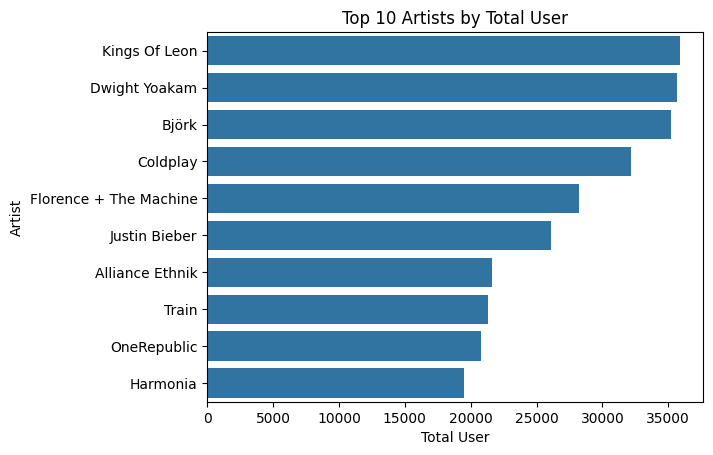

In [44]:
sns.barplot(x='Total User',
            y='Artist',
            data=top_10_artists
            ).set_title("Top 10 Artists by Total User")

In [45]:
popular = merged_df[['song_artist','song_name','play_count']]

artist_pop = popular.pivot_table(values=['play_count'],index = ['song_artist','song_name'] ,aggfunc = 'sum')

artist_pop = artist_pop.sort_values(by='play_count',ascending=False)

artist_pop = artist_pop.reset_index()

top_ten_artists_songs = artist_pop.head(10)

top_ten_artists_songs

,song_artist,song_name,play_count
0,Dwight Yoakam,You're The One,35432
1,Björk,Undo,33179
2,Kings Of Leon,Revelry,24359
3,Harmonia,Sehr kosmisch,19454
4,Barry Tuckwell/Academy of St Martin-in-the-Fie...,Horn Concerto No. 4 in E flat K495: II. Romanc...,17115
5,Florence + The Machine,Dog Days Are Over (Radio Edit),14279
6,OneRepublic,Secrets,12392
7,Sam Cooke,Ain't Misbehavin,11610
8,Tub Ring,Invalid,10794
9,Lonnie Gordon,Catch You Baby (Steve Pitron & Max Sanna Radio...,10515


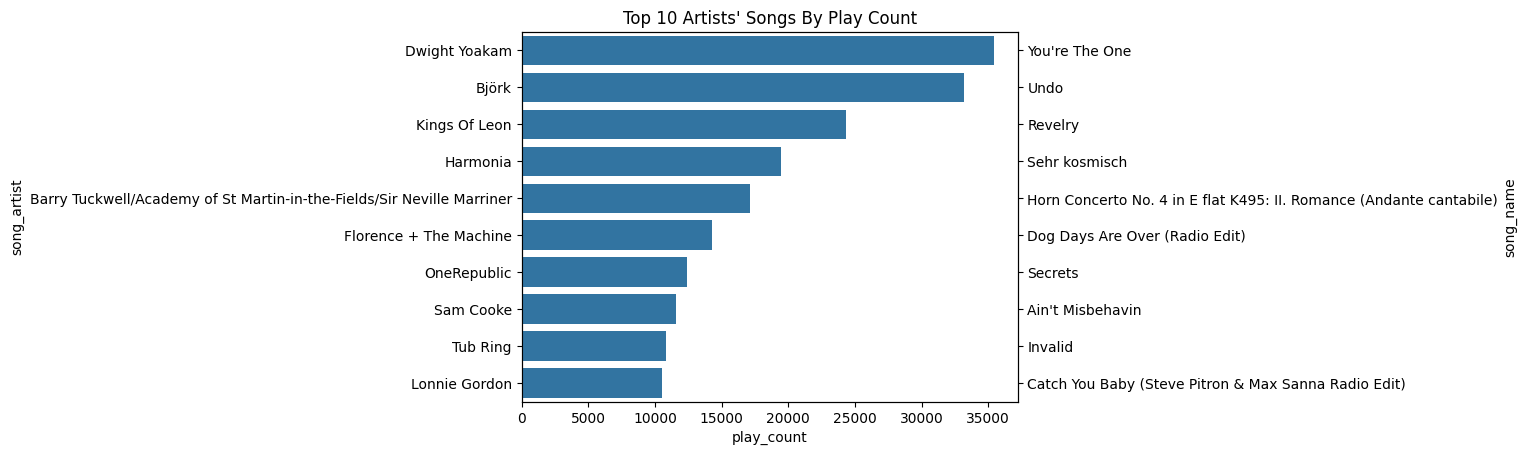

In [46]:
fig, ax1 = plt.subplots()

# Plot the first dataframe on ax1
sns.barplot(x=top_ten_artists_songs['play_count'], y=top_ten_artists_songs['song_artist'], ax=ax1)

# Create a second y-axis and plot the second dataframe
ax2 = ax1.twinx()
sns.barplot(x=top_ten_artists_songs['play_count'], y=top_ten_artists_songs['song_name'], ax=ax2)

plt.title("Top 10 Artists' Songs By Play Count")
plt.show()

Unique Values

In [47]:
print(f"No. of unique users: {merged_df['user_id'].nunique()}")
print(f"No. of unique songs: {merged_df['song_id'].nunique()}")
print(f"No. of unique play counts: {merged_df['play_count'].nunique()}")

No. of unique users: 110002
No. of unique songs: 163220
No. of unique play counts: 299


In [48]:
# Find out how many unique songs each artist has
unique_songs = merged_df.groupby('song_artist')['song_name'].nunique()

# Sort the artists by the number of unique songs in descending order
artists_most_unique = unique_songs.sort_values(ascending=False)

# Get the top 20 artists with the most unique songs
top_artist_unique_count = artists_most_unique.head(20)

# Convert the Series to a DataFrame
top_artist_unique_count = top_artist_unique_count.reset_index()
top_artist_unique_count.columns = ['song_artist', 'unique_song_count']

top_artist_unique_count

,song_artist,unique_song_count
0,Radiohead,88
1,Intocable,88
2,Ryan Adams,87
3,Red Hot Chili Peppers,85
4,Elliott Smith,84
5,Beastie Boys,82
6,Muse,81
7,Black Label Society,80
8,Van Halen,80
9,Cat Power,80


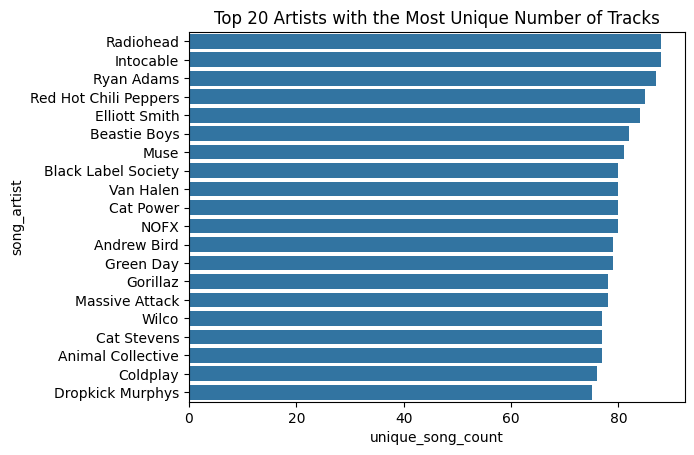

In [49]:
sns.barplot(x='unique_song_count',
            y='song_artist',
            data=top_artist_unique_count
            )
plt.title('Top 20 Artists with the Most Unique Number of Tracks')
plt.show()

Find artists that are quite popular but don't have a lot of unique tracks?

In [50]:
# Find out how many unique songs each artist has
unique_songs = merged_df.groupby('song_artist')['song_name'].nunique()

# Sort the artists by the number of unique songs in ascending order
artists_least_unique = unique_songs.sort_values(ascending=True)

# Get the top 20 artists with the most unique songs
artists_least_unique = artists_least_unique.head(20)

# Convert the Series to a DataFrame
artists_least_unique = artists_least_unique.reset_index()
artists_least_unique.columns = ['song_artist', 'unique_song_count']

artists_least_unique

,song_artist,unique_song_count
0,Sébastien Roch,0
1,Las Ondas Marteles,1
2,Lotta Engbergs,1
3,Lotus Eaters,1
4,Lou Bega,1
5,Lou Busch,1
6,Lou Johnson,1
7,Lou Rawls/Dianne Reeves,1
8,Lou Reed / The Velvet Underground,1
9,Loudon Wainwright III (Lucy Wainwright Roche),1


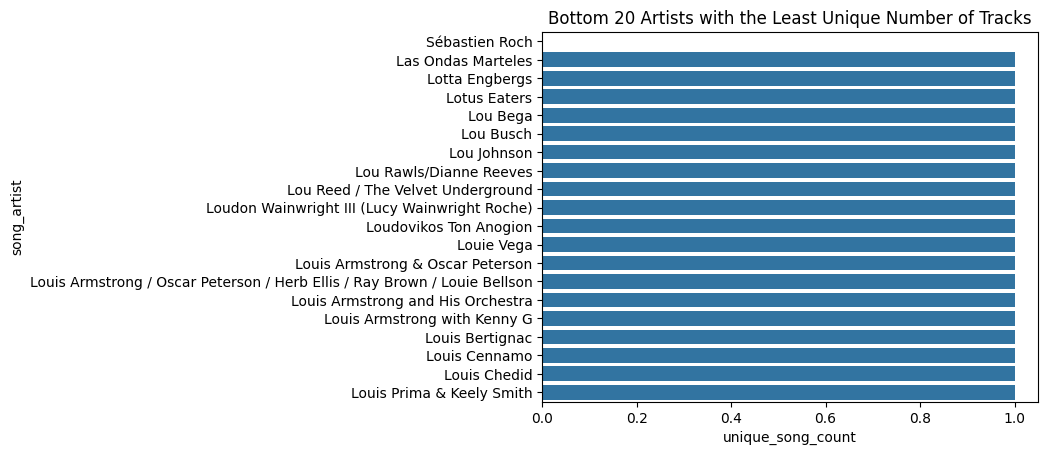

In [51]:
sns.barplot(x='unique_song_count',
            y='song_artist',
            data=artists_least_unique
            )
plt.title('Bottom 20 Artists with the Least Unique Number of Tracks')
plt.show()

Value Counts of Play Counts

Text(0.5, 1.0, 'Top 10 Play Counts (Binned)')

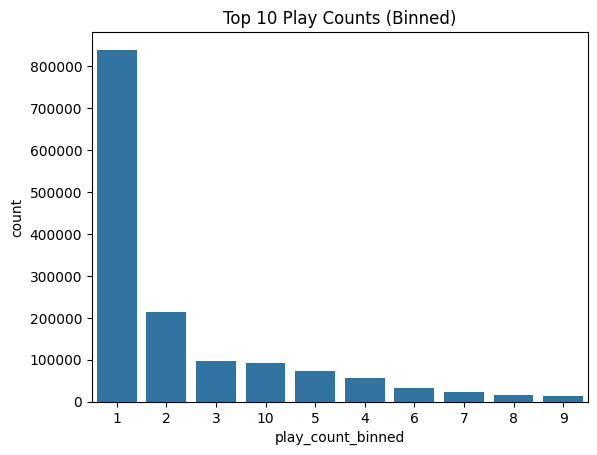

In [52]:
sns.countplot(merged_df,
              x='play_count_binned',
              order=merged_df['play_count_binned'].value_counts().index,
            ).set_title("Top 10 Play Counts (Binned)")

Top Frequency of Artists

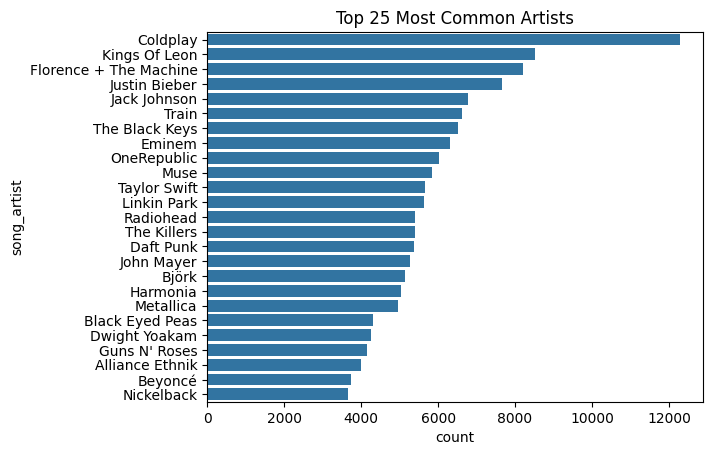

In [53]:
sns.countplot(merged_df,
              y='song_artist',
              order=merged_df['song_artist'].value_counts().nlargest(25).index
              )
plt.title('Top 25 Most Common Artists')
plt.show()

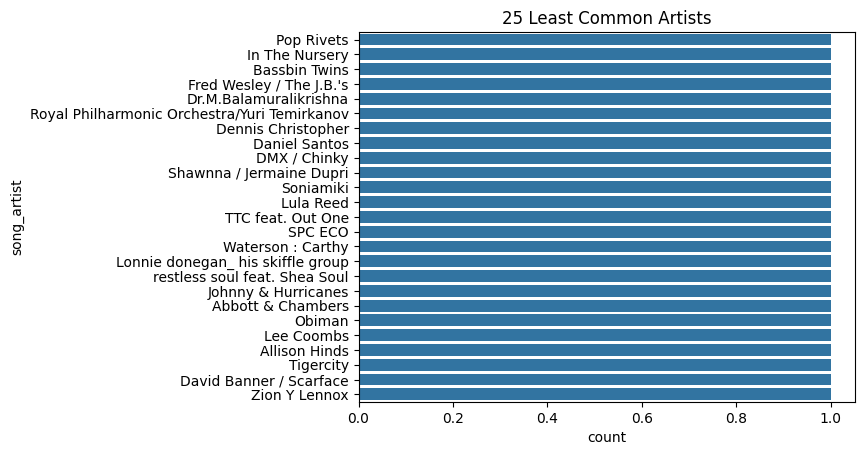

In [54]:
sns.countplot(merged_df,
              y='song_artist',
              order=merged_df['song_artist'].value_counts().nsmallest(25).index
              )
plt.title('25 Least Common Artists')
plt.show()

Top Frequency of Songs

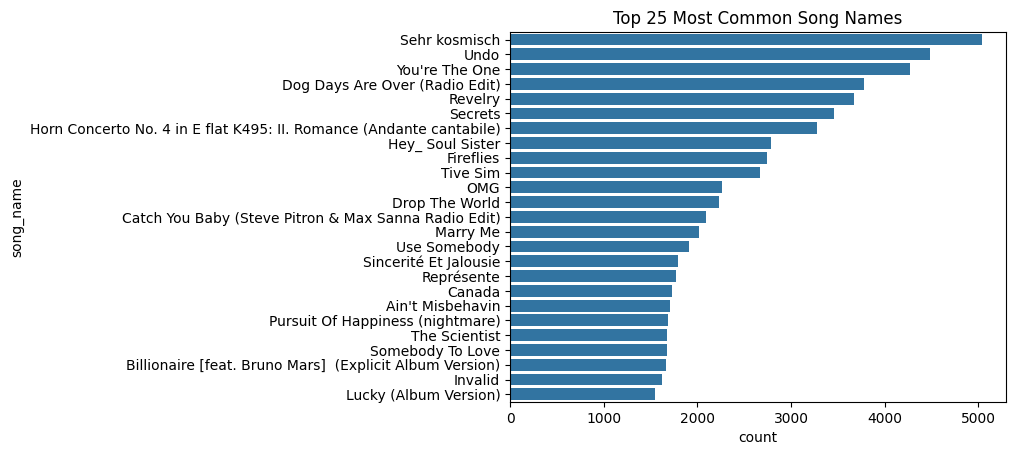

In [55]:
sns.countplot(merged_df,
              y='song_name',
              order=merged_df['song_name'].value_counts().nlargest(25).index
              )
plt.title('Top 25 Most Common Song Names')
plt.show()

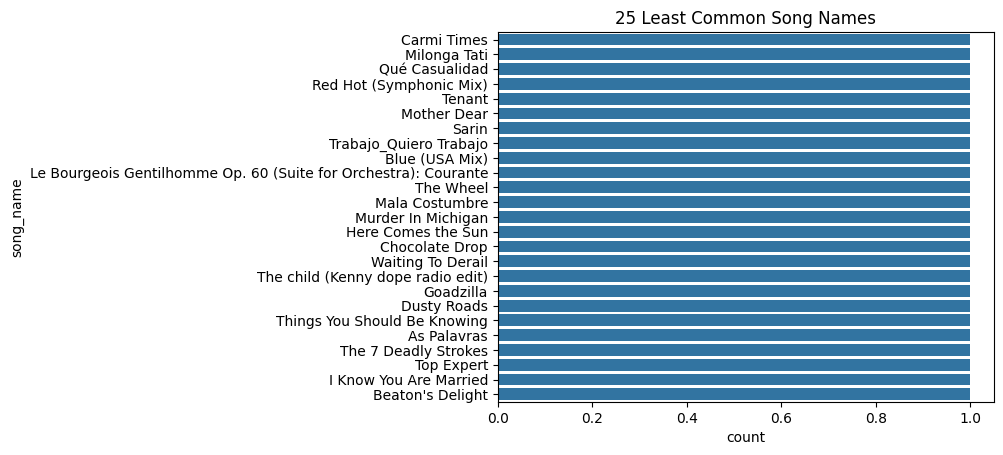

In [57]:
sns.countplot(merged_df,
              y='song_name',
              order=merged_df['song_name'].value_counts().nsmallest(25).index
              )
plt.title('25 Least Common Song Names')
plt.show()

---
### Naive Recommendation
- Top 10 Songs By Play Count
- Top 10 Songs by Most Popular Artists

In [56]:
top_ten_artists_songs

,song_artist,song_name,play_count
0,Dwight Yoakam,You're The One,35432
1,Björk,Undo,33179
2,Kings Of Leon,Revelry,24359
3,Harmonia,Sehr kosmisch,19454
4,Barry Tuckwell/Academy of St Martin-in-the-Fie...,Horn Concerto No. 4 in E flat K495: II. Romanc...,17115
5,Florence + The Machine,Dog Days Are Over (Radio Edit),14279
6,OneRepublic,Secrets,12392
7,Sam Cooke,Ain't Misbehavin,11610
8,Tub Ring,Invalid,10794
9,Lonnie Gordon,Catch You Baby (Steve Pitron & Max Sanna Radio...,10515


In [63]:
# Find out each artist's top song by play count
artist_song_pop = merged_df.groupby(['song_artist', 'song_name'])['play_count'].sum()

# Sort the songs by play count in descending order within each artist
artist_song_pop = artist_song_pop.sort_values(ascending=False).groupby('song_artist').head(1)

# Convert the Series to a DataFrame
artist_song_pop = artist_song_pop.reset_index()
artist_song_pop.columns = ['Artist', 'Song', 'Total Play Count']

# Get the top 10 artists and their most played song
top_10_artists_songs = artist_song_pop[artist_song_pop['Artist'].isin(top_10_artists['Artist'])]

top_10_artists_songs

,Artist,Song,Total Play Count
0,Dwight Yoakam,You're The One,35432
1,Björk,Undo,33179
2,Kings Of Leon,Revelry,24359
3,Harmonia,Sehr kosmisch,19454
5,Florence + The Machine,Dog Days Are Over (Radio Edit),14279
6,OneRepublic,Secrets,12392
11,Alliance Ethnik,Représente,9685
12,Train,Hey_ Soul Sister,8718
24,Justin Bieber,Somebody To Love,5162
35,Coldplay,The Scientist,4561


---
## Basic SVD Model
- SVD is a matrix factorization technique that is usually used in collaborative filtering recommender systems.

In [64]:
# --
reader = Reader(rating_scale=(merged_df['play_count_binned'].min(),
                              merged_df['play_count_binned'].max()))
data = Dataset.load_from_df(merged_df[['user_id','song_id','play_count_binned']], reader)


# test set is made of 30% of the ratings.
trainset, testset = train_test_split(data,test_size=0.3)

# We'll use the famous SVD algorithm.
algo = SVD(n_epochs=50, n_factors=200)

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 2.3335


2.333453203694307

Get Recommendations for Eric and I

In [65]:
def get_top_n_recommendations(user_id, data, model, n=10):
    # 1. Identify all unique songs in the dataset
    all_songs = data.df['song_id'].unique()

    # 2. Filter out the songs that the user has already reviewed
    reviewed_songs = data.df[data.df['user_id'] == user_id]['song_id'].unique()
    songs_to_predict = np.setdiff1d(all_songs, reviewed_songs)

    # 3. Use the model to predict the ratings for these songs
    predictions = [model.predict(user_id, beer).est for beer in songs_to_predict]

    # 4. Combine songs and predictions into a list of tuples and sort them
    song_predictions = list(zip(songs_to_predict, predictions))
    song_predictions.sort(key=lambda x: x[1], reverse=True)

    # Return the top n songs
    return song_predictions[:n]

# Example usage
user_id = 'Anthony Ayala'  # replace with the user ID
top_songs = get_top_n_recommendations(user_id, data, algo, n=10)
print(f"Top 10 Song Recommendations for : {user_id}")

for song_name, predicted_rating in top_songs:
    print(f"{song_name}: {predicted_rating:.4f}")

Top 10 Song Recommendations for : Anthony Ayala
SOTOECK12AAA8C6BB7: 9.7727
SOVIZNF12AF72A710A: 9.6046
SOJYISZ12A8C135F5A: 9.1114
SOQEPOY12A58A7CEE9: 9.0428
SOWNYGR12AB017C582: 8.9996
SOWMMQE12AB0182FF7: 8.9243
SOBMKJU12A6D4F7128: 8.8003
SOJZSWQ12A8C13BD47: 8.7935
SOGBOQX12A8C139DF7: 8.7821
SOQYQNL12AB01879F4: 8.7460


In [66]:
pred = pd.DataFrame(top_songs, columns=["song_id", "play_count"])
anthonys_first_merged_pred = pd.merge(pred, unique_tracks.drop_duplicates(['song_id']), how='left', on='song_id')
anthonys_first_merged_pred

,song_id,play_count,track_id,song_artist,song_name
0,SOTOECK12AAA8C6BB7,9.772651,TRQSZDX128F92F45D2,Renegade Soundwave,Pocket Porn (1990)
1,SOVIZNF12AF72A710A,9.604604,TRHNBHR128F9350E67,The Prodigy,The Big Gundown
2,SOJYISZ12A8C135F5A,9.111399,TRXFRRY128F42997E1,Shaggy / Samantha Cole,Luv Me_ Luv Me
3,SOQEPOY12A58A7CEE9,9.042763,TRWJJQI128F42412F0,Brotha Lynch Hung,Q-Ball
4,SOWNYGR12AB017C582,8.999625,TRWHKYM128F9314064,Kent,Vals för satan (din vän pessimisten)
5,SOWMMQE12AB0182FF7,8.924308,TRNIZXB128F9318EA9,Jim Jones & Ron Browz featuring Juelz Santana,Pop Champagne
6,SOBMKJU12A6D4F7128,8.800276,TRXKJKY128F14543EF,Cliff Richard & The Shadows,Nine Times Out Of Ten (1998 Digital Remaster)
7,SOJZSWQ12A8C13BD47,8.793452,TRIQRMM128F427227A,León Gieco,Canción Para Luchar
8,SOGBOQX12A8C139DF7,8.782101,TRWXPND128F4276583,Vienio & Pele,Automotywacja
9,SOQYQNL12AB01879F4,8.745975,TRSMDDV12903C9DD5A,Intro,Love Thang (LP Version)


Very Poor Recommendations
- Let's see what Eric's recommendations are

In [67]:
def get_top_n_recommendations(user_id, data, model, n=10):
    # 1. Identify all unique songs in the dataset
    all_songs = data.df['song_id'].unique()

    # 2. Filter out the songs that the user has already reviewed
    reviewed_songs = data.df[data.df['user_id'] == user_id]['song_id'].unique()
    songs_to_predict = np.setdiff1d(all_songs, reviewed_songs)

    # 3. Use the model to predict the ratings for these songs
    predictions = [model.predict(user_id, beer).est for beer in songs_to_predict]

    # 4. Combine songs and predictions into a list of tuples and sort them
    song_predictions = list(zip(songs_to_predict, predictions))
    song_predictions.sort(key=lambda x: x[1], reverse=True)

    # Return the top n songs
    return song_predictions[:n]

# Example usage
user_id = 'Eric M'  # replace with the user ID
top_songs = get_top_n_recommendations(user_id, data, algo, n=10)
print(f"Top 10 Song Recommendations for : {user_id}")

for song_name, predicted_rating in top_songs:
    print(f"{song_name}: {predicted_rating:.4f}")

Top 10 Song Recommendations for : Eric M
SOJSXJY12A8C13E32E: 5.7471
SONPZCD12A58A7B2E7: 5.2515
SOANOQW12A58A793D2: 5.2110
SOJZSWQ12A8C13BD47: 5.0624
SOTGNIO12AB0184317: 4.9954
SOACBLB12AB01871C7: 4.9460
SOWYRXW12A8C1351CA: 4.9439
SOFVUDO12A58A7B163: 4.9397
SOWYQDH12A67AE0FAA: 4.8958
SONXUQR12AB0186C9F: 4.8836


In [68]:
pred = pd.DataFrame(top_songs, columns=["song_id", "play_count"])
erics_first_merged_pred = pd.merge(pred, unique_tracks.drop_duplicates(['song_id']), how='left', on='song_id')
erics_first_merged_pred

,song_id,play_count,track_id,song_artist,song_name
0,SOJSXJY12A8C13E32E,5.747064,TRHRTYE128F427EA7D,Clara Hill,Clara meets Slope - Hard To Say
1,SONPZCD12A58A7B2E7,5.251498,TRFTKEY12903CE8211,Damnation A.d.,Two Steps Down
2,SOANOQW12A58A793D2,5.211025,TRXRALT128F932D8F6,The fFormula,Cold Blooded (Acid Cleanse)
3,SOJZSWQ12A8C13BD47,5.062398,TRIQRMM128F427227A,León Gieco,Canción Para Luchar
4,SOTGNIO12AB0184317,4.995391,TRCCXZQ128F930DE80,Delegation,One More Step To Take
5,SOACBLB12AB01871C7,4.946018,TRXBOYH12903CAE41F,keller williams,221
6,SOWYRXW12A8C1351CA,4.943899,TRMLIKM128F425F622,Joe Christmas,Bedroom Suite
7,SOFVUDO12A58A7B163,4.939734,TRDBJAJ128F1486EF1,Paul Stanley,Live To Win
8,SOWYQDH12A67AE0FAA,4.895845,TRXJMDH128EF33E049,Rey Gordiflón,Buenos Dias
9,SONXUQR12AB0186C9F,4.883566,TRHGBSJ12903CC64A7,Seine,So far so long


There is even stronger evidence that this model provided very poor recommendations as these artists are a completely different genre than what Eric likes and the artist he likes.
- Let's see how we can improve these recommendations?

## SVD Model and Baselines
---
In recommendation systems, baselines are simple models used as a point of comparison for more complex algorithms. **They are crucial for understanding how much better a sophisticated model is compared to a simple approach**. There are generally three types of baselines:

1. **Global Baseline**:
   - This is the simplest form of baseline. It involves calculating a **single average rating across all users and items in the dataset** and using this **average** as the **prediction for all user-item pairs**.
   - The global baseline is used as a starting point. *It doesn't account for individual user or item biases/preferences*.

2. **User Baseline**:
   - The user baseline model adjusts the global baseline by considering the bias (or deviation) specific to each user.
   - For instance, if a user tends to rate movies half a point higher than the average (say, the user's average rating is 4.0), this user bias (+0.5) is added to the global baseline to predict ratings for this user.
   - It provides a more personalized prediction than the global baseline by incorporating individual user tendencies, **but it still doesn't account for specific item characteristics**.

3. **Item Baseline**:
   - The item baseline adjusts the global baseline by considering the **bias specific to each item**.
   - For example, if a particular movie tends to be rated 0.3 points lower than the average, then this item bias (-0.3) is accounted for in the predictions.
   - This approach **recognizes that some items are inherently rated higher or lower than others**, regardless of the user.

These baseline models, are fundamental in recommendation systems and are  necessary for understanding the minimum performance that any sophisticated model should exceed to be considered valuable.

### Suprise Data Preparation
---

We have three intiall steps in our recipe to prepare the data for our Collaborative Filtering methods.


1. **Importing the Reader Class and Creating a Reader Object**:
    ```python
    reader = Reader(rating_scale=(1, 5))
    ```
    The `Reader` class is used to parse a file containing ratings. The parameter `rating_scale=(1, 5)` indicates that the rating scale goes from 1 to 5. In other words, it's telling the system that the ratings in your dataset will be integers between 1 and 5.

2. **Loading Data into Surprise's Format**:

    `Dataset.load_from_df()` is a method provided by scikit-surprise to load a dataset from a pandas DataFrame. Your DataFrame, `songs`, should have three columns: 'user', 'item', and 'rating'.
    - in our case "user_id", "song_id", and "play_count_binned"
  

3. **Splitting the Dataset into Training and Test Sets**:
    The `train_test_split` function splits datasets into random train and test subsets. The parameter `test_size=0.2` means that 20% of the data will be used for testing, and the remaining 80% will be used for training the model. The training set is used to fit the recommender system model, and the test set is used to evaluate its performance.

In [69]:
# -- initalize the data reader --
reader = Reader(rating_scale=(merged_df['play_count_binned'].min(),
                              merged_df['play_count_binned'].max()))
data = Dataset.load_from_df(merged_df[['user_id','song_id','play_count_binned']], reader)


# test set is made of 30% of the ratings.
trainset, testset = train_test_split(data,test_size=0.3)
trainset

The `Trainset` object in scikit-surprise is an optimal data format for building recommendation systems within the context of this library due to several reasons:

1. **Efficiency in Data Handling**:
   - The `Trainset` class is designed **specifically for recommendation systems**. It efficiently manages memory by internally converting raw user and item IDs into integer indices, which are faster to process.

2. **Support for Sparse Data**:
   - Recommendation datasets are often sparse (most user-item pairs do not have ratings).

3. **Compatibility with Algorithms**:
   - Scikit-surprise offers various recommendation algorithms (like SVD, KNN, NMF). The `Trainset` format is tailored to be directly compatible with these algorithms.


In [70]:
print(f"user count. : {trainset.n_users}")
print(f"item count. : {trainset.n_items}")
print(f"total play count: {trainset.n_ratings}")
print(f"play count range: {trainset.rating_scale}")


user count. : 109953
item count. : 141024
total play count: 1015666
play count range: (1, 10)


### Baseline Performance
---
In recommendation systems, baselines are simple models used as a point of comparison for more complex algorithms. **They are crucial for understanding how much better a sophisticated model is compared to a simple approach**. There are generally three types of baselines:

1. **Global Baseline**:
   - This is the simplest form of baseline. It involves calculating a **single average rating across all users and items in the dataset** and using this **average** as the **prediction for all user-item pairs**.
   - The global baseline is used as a starting point. *It doesn't account for individual user or item biases/preferences*.

2. **User Baseline**:
   - The user baseline model adjusts the global baseline by considering the bias (or deviation) specific to each user.
   - For instance, if a user tends to rate movies half a point higher than the average (say, the user's average rating is 4.0), this user bias (+0.5) is added to the global baseline to predict ratings for this user.
   - It provides a more personalized prediction than the global baseline by incorporating individual user tendencies, **but it still doesn't account for specific item characteristics**.

3. **Item Baseline**:
   - The item baseline adjusts the global baseline by considering the **bias specific to each item**.
   - For example, if a particular movie tends to be rated 0.3 points lower than the average, then this item bias (-0.3) is accounted for in the predictions.
   - This approach **recognizes that some items are inherently rated higher or lower than others**, regardless of the user.

These baseline models, are fundamental in recommendation systems and are  necessary for understanding the minimum performance that any sophisticated model should exceed to be considered valuable.

In [72]:
# Define and train the BaselineOnly model
print("Evaluating Global Mean Baseline:")
bsl_options = {'method': 'als',
               'n_epochs': 5,
               'reg_u': 5,
               'reg_i': 5}  # You can adjust these parameters
algo_global = BaselineOnly(bsl_options=bsl_options)
algo_global.fit(trainset)
# Predict ratings for the testset
predictions_global = algo_global.test(testset)
# Compute and print RMSE
rmse_global = accuracy.rmse(predictions_global)
# Compute and print MAE
mae_global = accuracy.mae(predictions_global)


Evaluating Global Mean Baseline:
Estimating biases using als...
RMSE: 2.2823
MAE:  1.6145


In [71]:

# Define and evaluate the user mean baseline
print("Evaluating User Mean Baseline:\n")
bsl_options = {
    'method': 'als',
    'n_epochs': 5,
    'reg_u': 5,     # Regular user regularization
    'reg_i': 100    # High item regularization to diminish item bias
}

#algo_user = BaselineOnly(bsl_options=bsl_options)
algo_user = BaselineOnly(bsl_options=bsl_options)
algo_user.fit(trainset)
# Predict ratings for the testset
predictions = algo_user.test(testset)
# Compute and print RMSE
rmse = accuracy.rmse(predictions)
# Compute and print MAE
mae = accuracy.mae(predictions)

Evaluating User Mean Baseline:

Estimating biases using als...
RMSE: 2.2810
MAE:  1.6198


In [73]:
# Define and evaluate the ITEM mean baseline
print("\nEvaluating Item Mean Baseline:\n")

bsl_options = {
    'method': 'als',
    'n_epochs': 5,
    'reg_u': 100,  # High user regularization to diminish user bias
    'reg_i': 5     # Regular item regularization
}
algo_item = BaselineOnly(bsl_options=bsl_options)
algo_item.fit(trainset)
# Predict ratings for the testset
predictions = algo_item.test(testset)
# Compute and print RMSE
rmse = accuracy.rmse(predictions)
# Compute and print MAE
mae = accuracy.mae(predictions)


Evaluating Item Mean Baseline:

Estimating biases using als...
RMSE: 2.4647
MAE:  1.8072


## SVD
---
Singular Value Decomposition (SVD) is a sophisticated matrix factorization technique commonly used in recommendation systems, particularly for collaborative filtering. Here's a simplified introduction to how SVD is used for recommendations:


1. **Using the SVD Algorithm**:
   ```python
   algo = SVD()
   ```
   - `SVD` stands for Singular Value Decomposition, a popular matrix factorization technique used in recommendation systems.
   - SVD is used to decompose your user-item rating matrix into matrices representing **latent (hidden) factors** for ***users and items***.

2. **Training the Algorithm**:
   ```python
   algo.fit(trainset)
   ```
   - `fit` is a method that trains the algorithm on the  `trainset`
   - SVD algorithm tries to learn the **latent factors that best approximate the original user-item rating matrix**. The goal is to minimize the difference between predicted and actual ratings in the training set, thereby learning the preferences and characteristics of users and items.
   - The training process involves iteratively adjusting the latent factors to minimize a loss function, typically the mean squared error between the predicted and actual ratings.


In [74]:
# Use the SVD algorithm
svd_model = SVD(
    n_epochs = 20,
    lr_all = 0.005,
    n_factors =  50,
    reg_all =  0.1
)

# Train the algorithm on the trainset
svd_model.fit(trainset)

# Access properties
user_factors = svd_model.pu
item_factors = svd_model.qi
user_biases = svd_model.bu
item_biases = svd_model.bi
global_mean = trainset.global_mean

# You can now analyze these properties, such as their shapes, distributions, etc.
print("User factors shape:", user_factors.shape)
print("Item factors shape:", item_factors.shape)

User factors shape: (109953, 50)
Item factors shape: (141024, 50)


## EVALUATE

In recommender systems, evaluation metrics are used to measure the accuracy and effectiveness of the model's predictions:

1. **Root Mean Squared Error (RMSE):**
   - RMSE is a standard way to measure the error of a model in predicting quantitative data.
   - Formula: \( \sqrt{\frac{1}{N} \sum (predicted\_rating - actual\_rating)^2} \)
   - It calculates the square root of the average squared difference between the actual ratings and the predicted ratings.
   - Lower RMSE values indicate better fit. An RMSE of 0 would mean perfect predictions.

2. **Mean Absolute Error (MAE):**
   - MAE measures the average magnitude of the errors in a set of predictions, without considering their direction.
   - Formula: \( \frac{1}{N} \sum |predicted\_rating - actual\_rating| \)
   - It calculates the average absolute difference between the predicted ratings and the actual ratings.
   - Similar to RMSE, a lower MAE indicates better predictions, and a MAE of 0 signifies perfect accuracy.


In [75]:
print("Evaluating SVD recomender model:\n")
# make predicitons
test_predictions = svd_model.test(testset)
# Compute and print RMSE
rmse = accuracy.rmse(test_predictions)

# Compute and print MAE
mae = accuracy.mae(test_predictions)


print("Evaluating SVD vs. Baseline:\n")
print(f"RMSE: {rmse:.4f} VS. baseline: {rmse_global:.4f}")
print(f"MAE: {mae:.4f} VS. baseline: {mae_global:.4f}")

Evaluating SVD recomender model:

RMSE: 2.3047
MAE:  1.6331
Evaluating SVD vs. Baseline:

RMSE: 2.3047 VS. baseline: 2.2823
MAE: 1.6331 VS. baseline: 1.6145


### Make a Prediction for Song and User

Prediction for a song that I like a lot?

In [76]:
# Predict rating for a sample user and song
sample_user = 'Anthony A'  # Replace with an user ID
sample_song = 'SOCYCKL12A58A79B1B'  # Replace with an song id , Lauyrn Hill's "Tell Him"
predicted_rating = svd_model.predict(sample_user, sample_song).est
print(f"prediction for user: {sample_user}")
print(f"prediction for song: {sample_song}")
print(f"rating {predicted_rating:.3f}")

prediction for user: Anthony A
prediction for song: SOCYCKL12A58A79B1B
rating 3.076


The model seems to calls for issues of accuracy, but let's further put the model to test. Now, I'll try to put a song that I did not have in my list to see if the model will perform better.
- I will choose a song from Eric's list and then choose another Lauryn Hill Song

In [77]:
# Predict rating for a sample user and song
sample_user = 'Anthony A'  # Replace with an user ID
sample_song = 'SONLSKL12A8C13CF26'  # Replace with an song id , Paramore's "Misery Business"
predicted_rating = svd_model.predict(sample_user, sample_song).est
print(f"prediction for user: {sample_user}")
print(f"prediction for song: {sample_song}")
print(f"rating {predicted_rating:.3f}")

prediction for user: Anthony A
prediction for song: SONLSKL12A8C13CF26
rating 2.372


In [78]:
# Predict rating for a sample user and song
sample_user = 'Anthony A'  # Replace with an user ID
sample_song = 'SOTIQGN12B0B80C00D'  # Replace with an song id , Lauyrn Hill's "I gotta find peace of mind"
predicted_rating = svd_model.predict(sample_user, sample_song).est
print(f"prediction for user: {sample_user}")
print(f"prediction for song: {sample_song}")
print(f"rating {predicted_rating:.3f}")

prediction for user: Anthony A
prediction for song: SOTIQGN12B0B80C00D
rating 2.413


Overall, the model's prediction are not doing a great job.

#### Top Recommendations

In [79]:
def get_top_n_recommendations(user_id, data, model, n=10):
    # 1. Identify all unique songs in the dataset
    all_songs = data.df['song_id'].unique()

    # 2. Filter out the songs that the user has already reviewed
    reviewed_songs = data.df[data.df['user_id'] == user_id]['song_id'].unique()
    songs_to_predict = np.setdiff1d(all_songs, reviewed_songs)

    # 3. Use the model to predict the ratings for these songs
    predictions = [model.predict(user_id, beer).est for beer in songs_to_predict]

    # 4. Combine songs and predictions into a list of tuples and sort them
    song_predictions = list(zip(songs_to_predict, predictions))
    song_predictions.sort(key=lambda x: x[1], reverse=True)

    # Return the top n songs
    return song_predictions[:n]

# Example usage
user_id = 'Anthony Ayala'  # replace with the user ID
top_songs = get_top_n_recommendations(user_id, data, svd_model, n=10)
print(f"Top 10 Song Recommendations for : {user_id}")

for song_name, predicted_rating in top_songs:
    print(f"{song_name}: {predicted_rating:.4f}")


Top 10 Song Recommendations for : Anthony Ayala
SOHYLXU12A8C139492: 10.0000
SOIOZHO12AB017FE5E: 10.0000
SOJYISZ12A8C135F5A: 10.0000
SOWHSGK12A6D4FC429: 10.0000
SOTLHUV12A6D4FC541: 9.9520
SOMTZYU12AB017D632: 9.9476
SOWMMQE12AB0182FF7: 9.9384
SOCNLEI12A67021565: 9.9081
SOWMBCE12A58A7B377: 9.8829
SOACBLB12AB01871C7: 9.8125


In [80]:
pred = pd.DataFrame(top_songs, columns=["song_id", "play_count"])
anthonys_second_merged_pred = pd.merge(pred, unique_tracks.drop_duplicates(['song_id']), how='left', on='song_id')
anthonys_second_merged_pred

,song_id,play_count,track_id,song_artist,song_name
0,SOHYLXU12A8C139492,10.000000,TRFLNTB128F427486F,Alejandro Sanz,Non E_ Per Te_ Per Me
1,SOIOZHO12AB017FE5E,10.000000,TRFDJKM128F92EE287,Philippe Rochard,Crumpshit
2,SOJYISZ12A8C135F5A,10.000000,TRXFRRY128F42997E1,Shaggy / Samantha Cole,Luv Me_ Luv Me
3,SOWHSGK12A6D4FC429,10.000000,TRXFDKV128F4231160,Bootsy Collins,Stretchin' Out (In A Rubber Band) (LP Version)
4,SOTLHUV12A6D4FC541,9.951954,TRMOPBS128F4227B51,Uncle Kracker,Follow Me (Explicit LP Version)
5,SOMTZYU12AB017D632,9.947613,TROTSZG128F93123E5,Joyce Cooling,It's Time I Go (Jazz)
6,SOWMMQE12AB0182FF7,9.938427,TRNIZXB128F9318EA9,Jim Jones & Ron Browz featuring Juelz Santana,Pop Champagne
7,SOCNLEI12A67021565,9.908115,TRZJSVZ128E079130F,The Velvet Underground / Nico,All Tomorrow's Parties
8,SOWMBCE12A58A7B377,9.882930,TRHIUQE128F427E268,Bachman-Turner Overdrive,Roll On Down The Highway
9,SOACBLB12AB01871C7,9.812503,TRXBOYH12903CAE41F,keller williams,221


I can see a slight improvement in predictions with the SVD model with seeing more artists I am familar with, but it's still not good enough of a model for predicting. However, the concern is consistency

In [81]:
anthonys_song_predictions = pd.concat([anthonys_first_merged_pred,anthonys_second_merged_pred],axis=0)
anthonys_song_predictions

,song_id,play_count,track_id,song_artist,song_name
0,SOTOECK12AAA8C6BB7,9.772651,TRQSZDX128F92F45D2,Renegade Soundwave,Pocket Porn (1990)
1,SOVIZNF12AF72A710A,9.604604,TRHNBHR128F9350E67,The Prodigy,The Big Gundown
2,SOJYISZ12A8C135F5A,9.111399,TRXFRRY128F42997E1,Shaggy / Samantha Cole,Luv Me_ Luv Me
3,SOQEPOY12A58A7CEE9,9.042763,TRWJJQI128F42412F0,Brotha Lynch Hung,Q-Ball
4,SOWNYGR12AB017C582,8.999625,TRWHKYM128F9314064,Kent,Vals för satan (din vän pessimisten)
5,SOWMMQE12AB0182FF7,8.924308,TRNIZXB128F9318EA9,Jim Jones & Ron Browz featuring Juelz Santana,Pop Champagne
6,SOBMKJU12A6D4F7128,8.800276,TRXKJKY128F14543EF,Cliff Richard & The Shadows,Nine Times Out Of Ten (1998 Digital Remaster)
7,SOJZSWQ12A8C13BD47,8.793452,TRIQRMM128F427227A,León Gieco,Canción Para Luchar
8,SOGBOQX12A8C139DF7,8.782101,TRWXPND128F4276583,Vienio & Pele,Automotywacja
9,SOQYQNL12AB01879F4,8.745975,TRSMDDV12903C9DD5A,Intro,Love Thang (LP Version)


No Changes in Predictions, which makes sense since the baseline performance and SVD didn't have much of a performance difference anyway

In [82]:
# Top 5 Most Reviewers
merged_df['user_id'].value_counts().nlargest(5)

7d90be8dfdbde170f036ce8a4b915440137cb11c    53
0f8308935bcbb9a1e04ebb7c4d41c037e5f23b90    52
03ad93fdb01506ce205f4708decf8e4b1ae90fff    52
d30e18323f15426c3cdc8585252ed34459916f51    52
2e424b28bff1f62a2dae22a918f09f9c30c06d1b    52
Name: user_id, dtype: int64

In [83]:
#user_id = ''  replace with the user ID
for user_id in merged_df['user_id'].value_counts().nlargest(5).index:
  top_songs = get_top_n_recommendations(user_id, data, svd_model, n=10)
  print(f"-- Top 10 Song Recommendations for : {user_id} -- ")
  for song_id, predicted_rating in top_songs:
      print(f"{song_id}: {predicted_rating:.4f}")
  print("\n")

-- Top 10 Song Recommendations for : 7d90be8dfdbde170f036ce8a4b915440137cb11c -- 
SOWYRXW12A8C1351CA: 5.1598
SOJSXJY12A8C13E32E: 4.9929
SODWFXL12A6D4FB509: 4.8584
SOMRCJE12B0B80BB69: 4.8143
SOXXSVC12A582A242D: 4.6831
SOFPXXK12A6D4FA1D9: 4.6767
SOFTHHP12A6D4F8B4E: 4.6525
SOKUJSV12A8C130282: 4.6416
SOQPVXI12A6D4F7DC6: 4.6228
SOANOQW12A58A793D2: 4.6048


-- Top 10 Song Recommendations for : 0f8308935bcbb9a1e04ebb7c4d41c037e5f23b90 -- 
SOTUARP12A8C13CB54: 6.6997
SOHFGKG12A6701C429: 6.1785
SOYWBDC12A8C142D90: 5.7444
SORHUJT12A8C13B85E: 5.6812
SOWYRXW12A8C1351CA: 5.5875
SOTGNIO12AB0184317: 5.5562
SOQBUFQ12A6D4F7F4C: 5.3535
SONENUZ12A8C14230C: 5.2879
SOCUCRW12A8C13B159: 5.2673
SOXXSVC12A582A242D: 5.1750


-- Top 10 Song Recommendations for : 03ad93fdb01506ce205f4708decf8e4b1ae90fff -- 
SOTVLHC12A6701EA31: 6.5582
SOWYRXW12A8C1351CA: 6.4886
SOXXSVC12A582A242D: 5.7632
SOTGNIO12AB0184317: 5.7107
SOJSXJY12A8C13E32E: 5.6710
SOIMTII12A6D4F662A: 5.5362
SOQGSUC12A8C13B66D: 5.3138
SONPCAF12A81C21DE9: 5

### Question 1: For a random sample of 5 users with 10 or more song plays make 5 recommendations of songs they have not listened to with your SVD.

In [84]:
random_users = merged_df.query("play_count >= 10").sample(n=5)
random_users = random_users['user_id'].values

# Convert numpy array to a list
random_users_list = random_users.tolist()

# Show the list
print("Random Users List:" , random_users_list)

Random Users List: ['080b582149a315212a77c05776673be88ee6cf5a', '1d167fc4267c2b5f868e3fa77b7df3619a716e93', '5cbfec31d7695e9ef5d3b754594a86a3885a4fe1', 'aa3a85676b63b84692b08707c3086340a8316073', '95b5cdef902aba03af6a85aa6c45c8ca9f093e54']


In [85]:
# Create recommendations for the random list of users
for user_id in random_users_list:
    top_songs = get_top_n_recommendations(user_id, data, svd_model, n=5)
    print(f"-- Top 10 Song Recommendations for : {user_id} -- ")

    # Create a DataFrame from the predictions
    predictions_df = pd.DataFrame(top_songs, columns=['song_id', 'predicted_rating'])

    # Left join the predictions to the unique tracks DataFrame
    merged_predictions_df = pd.merge(predictions_df, unique_tracks, on='song_id', how='left')

    for index, row in merged_predictions_df.iterrows():
        print(f":{row['song_artist']}: {row['song_name']}: {row['song_id']}: {row['predicted_rating']:.4f} :")
    print("\n")

-- Top 10 Song Recommendations for : 080b582149a315212a77c05776673be88ee6cf5a -- 
:Jag Panzer: Reign Of The Tyrants: SOIMTII12A6D4F662A: 6.0688 :
:Julie London: You'd Be So Nice To Come Home To: SOXQWUS12A58A7B236: 6.0508 :
:Jim Jones & Ron Browz featuring Juelz Santana: Pop Champagne: SOWMMQE12AB0182FF7: 6.0029 :
:Joe Christmas: Bedroom Suite: SOWYRXW12A8C1351CA: 5.7496 :
:Old 97's: Victoria (LP Version): SOSJSSU12A6D4F8F41: 5.6958 :


-- Top 10 Song Recommendations for : 1d167fc4267c2b5f868e3fa77b7df3619a716e93 -- 
:Joe Christmas: Bedroom Suite: SOWYRXW12A8C1351CA: 7.0330 :
:The Special AKA: Bright Lights (Instrumental): SONPCAF12A81C21DE9: 6.6889 :
:Pearl Jam: Encore Break: SOVMADB12A8C137B96: 6.3512 :
:keller williams: 221: SOACBLB12AB01871C7: 6.3218 :
:Old 97's: Victoria (LP Version): SOSJSSU12A6D4F8F41: 6.2216 :


-- Top 10 Song Recommendations for : 5cbfec31d7695e9ef5d3b754594a86a3885a4fe1 -- 
:Clara Hill: Clara meets Slope - Hard To Say: SOJSXJY12A8C13E32E: 6.4700 :
:Alceu Vale

---
## How to improve the SVD Model with K-Fold
- Let's try to fit the model on the whole data set

In [86]:
# Use the SVD algorithm
svd_model = SVD(
    n_epochs = 20,
    lr_all = 0.005,
    n_factors =  50,
    reg_all =  0.1
)

# Train the algorithm on the trainset
svd_model.fit(trainset)

# Access properties
user_factors = svd_model.pu
item_factors = svd_model.qi
user_biases = svd_model.bu
item_biases = svd_model.bi
global_mean = trainset.global_mean

# You can now analyze these properties, such as their shapes, distributions, etc.
print("User factors shape:", user_factors.shape)
print("Item factors shape:", item_factors.shape)

User factors shape: (109953, 50)
Item factors shape: (141024, 50)


In [87]:
#from surprise.model_selection import GridSearchCV

#param_grid = {
    #'n_factors': [50, 100, 150],
    #'n_epochs': [5, 10, 20],
    #'lr_all': [0.002, 0.005],
    #'reg_all': [0.02, 0.05]
#}

#gs = GridSearchCV(SVD, param_grid, measures=['RMSE', 'MAE'], cv=3)
#gs.fit(data)

# best RMSE score
#print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
#print(gs.best_params['rmse'])

In [88]:
#gs.cv_results

In [89]:
#results = gs.cv_results
# Convert the dictionary into a Pandas DataFrame
#results_df = pd.DataFrame.from_dict(results)

# Filter the DataFrame to show only the relevant columns
#relevant_columns = ['param_n_factors', 'param_n_epochs', 'param_lr_all', 'param_reg_all', 'mean_test_rmse', 'mean_test_mae']
#svd_k_fold_results_df = results_df[relevant_columns]

# Print the DataFrame
#svd_k_fold_results_df

In [90]:
# Create an excel file
#svd_k_fold_results_df.to_csv('svd_k_fold_results_music.csv')

In [91]:
# Read the excel file
results_df =  pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Ames Projects Python and SQL/svd_k_fold_results_music.csv")

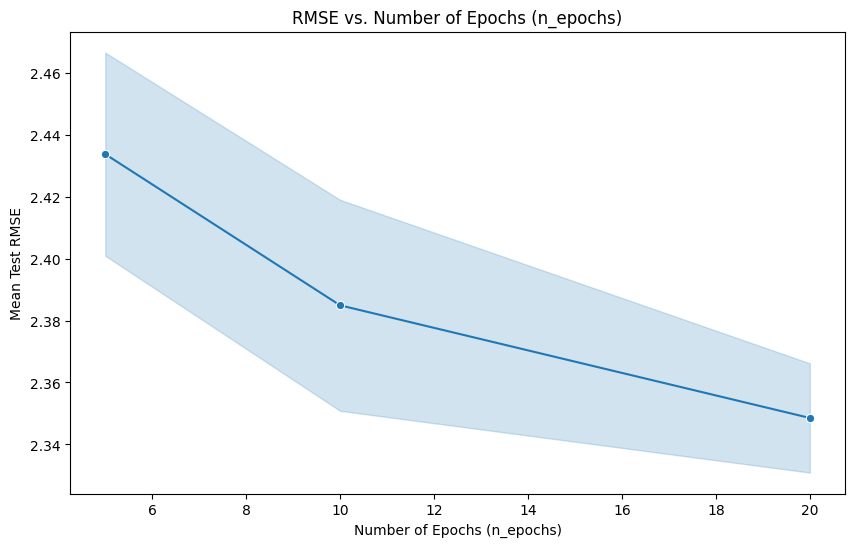

In [92]:
filtered_df = results_df[results_df['param_n_factors'] == 100]
# Creating the line plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=filtered_df, x='param_n_epochs', y='mean_test_rmse', marker='o')
plt.title('RMSE vs. Number of Epochs (n_epochs)')
plt.xlabel('Number of Epochs (n_epochs)')
plt.ylabel('Mean Test RMSE')
plt.show()

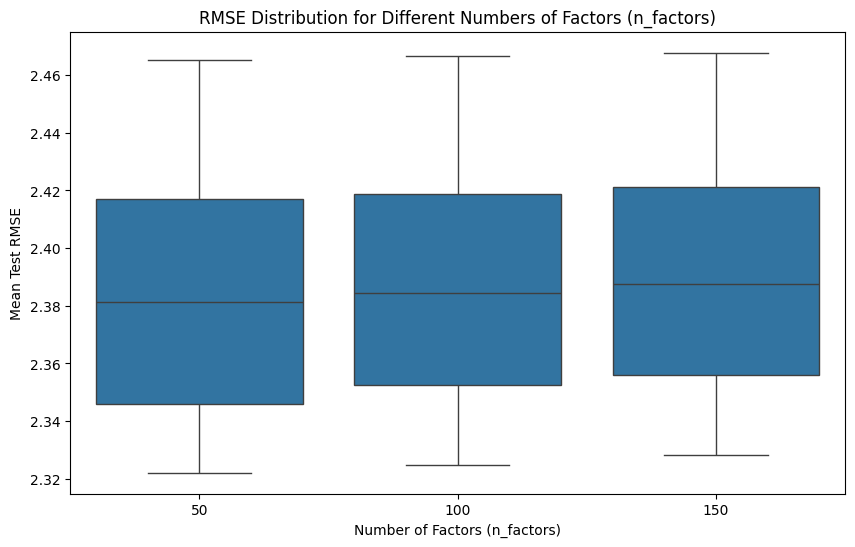

In [93]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=results_df, x='param_n_factors', y='mean_test_rmse')
plt.title('RMSE Distribution for Different Numbers of Factors (n_factors)')
plt.xlabel('Number of Factors (n_factors)')
plt.ylabel('Mean Test RMSE')
plt.show()

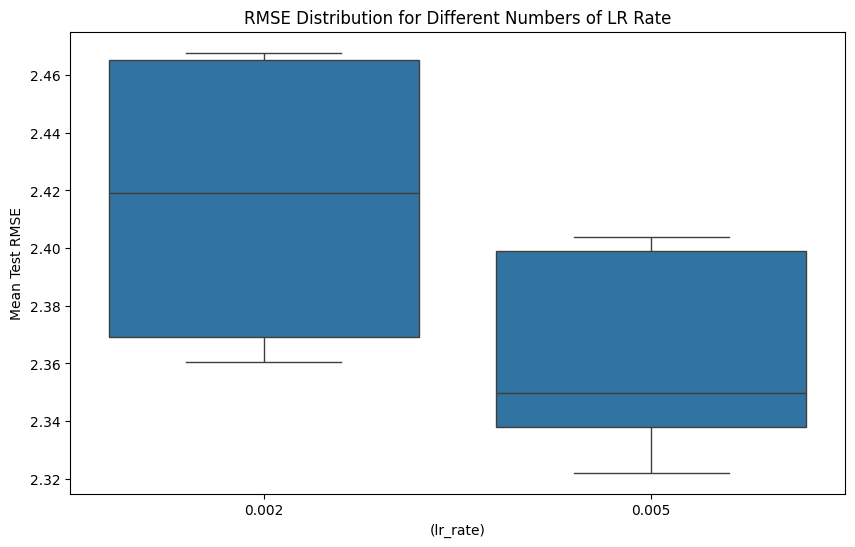

In [94]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=results_df, x='param_lr_all', y='mean_test_rmse')
plt.title('RMSE Distribution for Different Numbers of LR Rate')
plt.xlabel('(lr_rate)')
plt.ylabel('Mean Test RMSE')
plt.show()

## Refit w. Best Parameters

In [95]:
#best_params = gs.best_params['rmse']
#svd_model = SVD(n_factors=best_params['n_factors'], n_epochs=best_params['n_epochs'], lr_all=best_params['lr_all'], reg_all=best_params['reg_all'])
#svd_model.fit(trainset)

#print("Evaluating SVD recomender model:\n")
# make predicitons
#test_predictions = svd_model.test(testset)
# Compute and print RMSE
#rmse = accuracy.rmse(test_predictions)

# Compute and print MAE
#mae = accuracy.mae(test_predictions)

#print("Evaluating SVD:\n")
#print(f"RMSE: {rmse:.4f} ")
#print(f"MAE: {mae:.4f} ")

In [96]:
best_params = 2.322113017295591
svd_model = SVD(n_factors=50, n_epochs=20, lr_all=0.005, reg_all=0.05)
svd_model.fit(trainset)

print("Evaluating SVD recomender model:\n")
# make predicitons
test_predictions = svd_model.test(testset)
# Compute and print RMSE
rmse = accuracy.rmse(test_predictions)

# Compute and print MAE
mae = accuracy.mae(test_predictions)

print("Evaluating SVD:\n")
print(f"RMSE: {rmse:.4f} ")
print(f"MAE: {mae:.4f} ")

Evaluating SVD recomender model:

RMSE: 2.3181
MAE:  1.6392
Evaluating SVD:

RMSE: 2.3181 
MAE: 1.6392 


In [97]:
# Predict rating for a sample user and song
sample_user = 'Anthony A'  # Replace with an user ID
sample_song = 'SOCYCKL12A58A79B1B'  # Replace with an song id , Lauyrn Hill's "Tell Him"
predicted_rating = svd_model.predict(sample_user, sample_song).est
print(f"prediction for user: {sample_user}")
print(f"prediction for song: {sample_song}")
print(f"rating {predicted_rating:.3f}")

prediction for user: Anthony A
prediction for song: SOCYCKL12A58A79B1B
rating 3.084


Slight improvement in prediction.

### Top Recommendations

In [98]:
def get_top_n_recommendations(user_id, data, model, n=10):
    # 1. Identify all unique songs in the dataset
    all_songs = data.df['song_id'].unique()

    # 2. Filter out the songs that the user has already reviewed
    reviewed_songs = data.df[data.df['user_id'] == user_id]['song_id'].unique()
    songs_to_predict = np.setdiff1d(all_songs, reviewed_songs)

    # 3. Use the model to predict the ratings for these songs
    predictions = [model.predict(user_id, beer).est for beer in songs_to_predict]

    # 4. Combine songs and predictions into a list of tuples and sort them
    song_predictions = list(zip(songs_to_predict, predictions))
    song_predictions.sort(key=lambda x: x[1], reverse=True)

    # Return the top n songs
    return song_predictions[:n]

# Example usage
user_id = 'Anthony Ayala'  # replace with the user ID
top_songs = get_top_n_recommendations(user_id, data, svd_model, n=10)
print(f"Top 10 Song Recommendations for : {user_id}")

for song_name, predicted_rating in top_songs:
    print(f"{song_name}: {predicted_rating:.4f}")

Top 10 Song Recommendations for : Anthony Ayala
SOBONKR12A58A7A7E0: 10.0000
SOCHWPT12AB0184F15: 10.0000
SOIMTII12A6D4F662A: 10.0000
SOJSXJY12A8C13E32E: 10.0000
SOKUBOH12A8C131BD1: 10.0000
SONDKOF12A6D4F7D70: 10.0000
SOWYRXW12A8C1351CA: 10.0000
SOXXSVC12A582A242D: 10.0000
SOYABSZ12A81C1FEAC: 10.0000
SOYTDBL12A6D4F8148: 10.0000


In [99]:
pred = pd.DataFrame(top_songs, columns=["song_id", "play_count"])
anthonys_third_merged_pred = pd.merge(pred, unique_tracks.drop_duplicates(['song_id']), how='left', on='song_id')
anthonys_third_merged_pred

,song_id,play_count,track_id,song_artist,song_name
0,SOBONKR12A58A7A7E0,10,TRAEHHJ12903CF492F,Dwight Yoakam,You're The One
1,SOCHWPT12AB0184F15,10,TRJZLIF12903CAA7A4,Kix,Girl Money
2,SOIMTII12A6D4F662A,10,TRGWVYH12903D019BA,Jag Panzer,Reign Of The Tyrants
3,SOJSXJY12A8C13E32E,10,TRHRTYE128F427EA7D,Clara Hill,Clara meets Slope - Hard To Say
4,SOKUBOH12A8C131BD1,10,TRBDCXE128F4268C1D,Kris Kross,Jump
5,SONDKOF12A6D4F7D70,10,TRVSHJE128F1475018,Alceu Valença,Recado Falado (Metrô Da Saudade)
6,SOWYRXW12A8C1351CA,10,TRMLIKM128F425F622,Joe Christmas,Bedroom Suite
7,SOXXSVC12A582A242D,10,TRTAVWJ128E078DA2A,Jake Hess,Death Ain't No Big Deal (Tribute To Jake Hess ...
8,SOYABSZ12A81C1FEAC,10,TRHRNJY128F42530E2,Reality Check,Masquerade (Reality Check Album Version)
9,SOYTDBL12A6D4F8148,10,TRHUJDI128F146A5D8,Sauce Money Featuring Memphis Bleek,What We Do (Explicit) (Feat. Memphis Bleek)


Slight improvement

In [100]:
anthonys_song_predictions = pd.concat([anthonys_third_merged_pred,anthonys_song_predictions],axis=0)
anthonys_song_predictions

,song_id,play_count,track_id,song_artist,song_name
0,SOBONKR12A58A7A7E0,10.000000,TRAEHHJ12903CF492F,Dwight Yoakam,You're The One
1,SOCHWPT12AB0184F15,10.000000,TRJZLIF12903CAA7A4,Kix,Girl Money
2,SOIMTII12A6D4F662A,10.000000,TRGWVYH12903D019BA,Jag Panzer,Reign Of The Tyrants
3,SOJSXJY12A8C13E32E,10.000000,TRHRTYE128F427EA7D,Clara Hill,Clara meets Slope - Hard To Say
4,SOKUBOH12A8C131BD1,10.000000,TRBDCXE128F4268C1D,Kris Kross,Jump
5,SONDKOF12A6D4F7D70,10.000000,TRVSHJE128F1475018,Alceu Valença,Recado Falado (Metrô Da Saudade)
6,SOWYRXW12A8C1351CA,10.000000,TRMLIKM128F425F622,Joe Christmas,Bedroom Suite
7,SOXXSVC12A582A242D,10.000000,TRTAVWJ128E078DA2A,Jake Hess,Death Ain't No Big Deal (Tribute To Jake Hess ...
8,SOYABSZ12A81C1FEAC,10.000000,TRHRNJY128F42530E2,Reality Check,Masquerade (Reality Check Album Version)
9,SOYTDBL12A6D4F8148,10.000000,TRHUJDI128F146A5D8,Sauce Money Featuring Memphis Bleek,What We Do (Explicit) (Feat. Memphis Bleek)


In [101]:
def get_top_n_recommendations(user_id, data, model, n=10):
    # 1. Identify all unique songs in the dataset
    all_songs = data.df['song_id'].unique()

    # 2. Filter out the songs that the user has already reviewed
    reviewed_songs = data.df[data.df['user_id'] == user_id]['song_id'].unique()
    songs_to_predict = np.setdiff1d(all_songs, reviewed_songs)

    # 3. Use the model to predict the ratings for these songs
    predictions = [model.predict(user_id, beer).est for beer in songs_to_predict]

    # 4. Combine songs and predictions into a list of tuples and sort them
    song_predictions = list(zip(songs_to_predict, predictions))
    song_predictions.sort(key=lambda x: x[1], reverse=True)

    # Return the top n songs
    return song_predictions[:n]

# Example usage
user_id = 'Eric M'  # replace with the user ID
top_songs = get_top_n_recommendations(user_id, data, svd_model, n=10)
print(f"Top 10 Song Recommendations for : {user_id}")

for song_name, predicted_rating in top_songs:
    print(f"{song_name}: {predicted_rating:.4f}")

Top 10 Song Recommendations for : Eric M
SOJSXJY12A8C13E32E: 6.1661
SOXXSVC12A582A242D: 5.9257
SOANOQW12A58A793D2: 5.6288
SOWYRXW12A8C1351CA: 5.4683
SONPCAF12A81C21DE9: 5.4079
SOACBLB12AB01871C7: 5.3851
SOZJUSJ12A8C13C249: 5.2729
SOCUCRW12A8C13B159: 5.2299
SOFVUDO12A58A7B163: 5.1705
SONXUQR12AB0186C9F: 5.0964


In [102]:
pred = pd.DataFrame(top_songs, columns=["song_id", "play_count"])
erics_seconds_merged_pred = pd.merge(pred, unique_tracks.drop_duplicates(['song_id']), how='left', on='song_id')
erics_seconds_merged_pred

,song_id,play_count,track_id,song_artist,song_name
0,SOJSXJY12A8C13E32E,6.166097,TRHRTYE128F427EA7D,Clara Hill,Clara meets Slope - Hard To Say
1,SOXXSVC12A582A242D,5.925707,TRTAVWJ128E078DA2A,Jake Hess,Death Ain't No Big Deal (Tribute To Jake Hess ...
2,SOANOQW12A58A793D2,5.628787,TRXRALT128F932D8F6,The fFormula,Cold Blooded (Acid Cleanse)
3,SOWYRXW12A8C1351CA,5.468308,TRMLIKM128F425F622,Joe Christmas,Bedroom Suite
4,SONPCAF12A81C21DE9,5.407887,TRQMLFR128F422F169,The Special AKA,Bright Lights (Instrumental)
5,SOACBLB12AB01871C7,5.385077,TRXBOYH12903CAE41F,keller williams,221
6,SOZJUSJ12A8C13C249,5.272935,TRYASXH128F428D988,Black Oak Arkansas,Swimmin' In Quicksand (2006 Remastered LP Vers...
7,SOCUCRW12A8C13B159,5.229855,TRDTVMO128F4271696,Guildo Horn,Ein Kleiner Matrose
8,SOFVUDO12A58A7B163,5.170488,TRDBJAJ128F1486EF1,Paul Stanley,Live To Win
9,SONXUQR12AB0186C9F,5.096430,TRHGBSJ12903CC64A7,Seine,So far so long


In [103]:
erics_song_predictions = pd.concat([erics_seconds_merged_pred,erics_first_merged_pred],axis=0)
erics_song_predictions

,song_id,play_count,track_id,song_artist,song_name
0,SOJSXJY12A8C13E32E,6.166097,TRHRTYE128F427EA7D,Clara Hill,Clara meets Slope - Hard To Say
1,SOXXSVC12A582A242D,5.925707,TRTAVWJ128E078DA2A,Jake Hess,Death Ain't No Big Deal (Tribute To Jake Hess ...
2,SOANOQW12A58A793D2,5.628787,TRXRALT128F932D8F6,The fFormula,Cold Blooded (Acid Cleanse)
3,SOWYRXW12A8C1351CA,5.468308,TRMLIKM128F425F622,Joe Christmas,Bedroom Suite
4,SONPCAF12A81C21DE9,5.407887,TRQMLFR128F422F169,The Special AKA,Bright Lights (Instrumental)
5,SOACBLB12AB01871C7,5.385077,TRXBOYH12903CAE41F,keller williams,221
6,SOZJUSJ12A8C13C249,5.272935,TRYASXH128F428D988,Black Oak Arkansas,Swimmin' In Quicksand (2006 Remastered LP Vers...
7,SOCUCRW12A8C13B159,5.229855,TRDTVMO128F4271696,Guildo Horn,Ein Kleiner Matrose
8,SOFVUDO12A58A7B163,5.170488,TRDBJAJ128F1486EF1,Paul Stanley,Live To Win
9,SONXUQR12AB0186C9F,5.096430,TRHGBSJ12903CC64A7,Seine,So far so long


### Make a Prediction for top five music reviewers and Songs

In [104]:
# Top 5 Most Reviewers
merged_df['user_id'].value_counts().nlargest(5)

7d90be8dfdbde170f036ce8a4b915440137cb11c    53
0f8308935bcbb9a1e04ebb7c4d41c037e5f23b90    52
03ad93fdb01506ce205f4708decf8e4b1ae90fff    52
d30e18323f15426c3cdc8585252ed34459916f51    52
2e424b28bff1f62a2dae22a918f09f9c30c06d1b    52
Name: user_id, dtype: int64

In [105]:
#user_id = ''  replace with the user ID
for user_id in merged_df['user_id'].value_counts().nlargest(5).index:
  top_songs = get_top_n_recommendations(user_id, data, svd_model, n=5)
  print(f"-- Top 5 Song Recommendations for : {user_id} -- ")

  # Create a DataFrame from the predictions
  predictions_df = pd.DataFrame(top_songs, columns=['song_id', 'predicted_rating'])

  # Left join the predictions to the unique tracks DataFrame
  merged_predictions_df = pd.merge(predictions_df, unique_tracks, on='song_id', how='left')

  for index, row in merged_predictions_df.iterrows():
      print(f":{row['song_artist']}: {row['song_name']}: {row['song_id']}: {row['predicted_rating']:.4f} :")
  print("\n")

-- Top 5 Song Recommendations for : 7d90be8dfdbde170f036ce8a4b915440137cb11c -- 
:Jake Hess: Death Ain't No Big Deal (Tribute To Jake Hess Album Version): SOXXSVC12A582A242D: 5.6383 :
:Ron Carter: I CAN'T GET STARTED: SOUNZHU12A8AE47481: 5.5609 :
:Clara Hill: Clara meets Slope - Hard To Say: SOJSXJY12A8C13E32E: 5.4328 :
:Pavement: Heaven Is A Truck: SOSDVSH12A81356D41: 5.2709 :
:The Special AKA: Bright Lights (Instrumental): SONPCAF12A81C21DE9: 5.1916 :


-- Top 5 Song Recommendations for : 0f8308935bcbb9a1e04ebb7c4d41c037e5f23b90 -- 
:Joe Christmas: Bedroom Suite: SOWYRXW12A8C1351CA: 6.5791 :
:George Dalaras: Bros Sto Rimagmeno Spiti (2003 Digital Remaster): SOFWKCI12A8C13A22A: 6.3556 :
:Armin van Buuren: Never Say Never: SOSGEGU12AB018188A: 6.3323 :
:Streetlight Manifesto: Keasbey Nights (LP Version): SOCVOVH12A6D4FB912: 6.2625 :
:Jim Jones & Ron Browz featuring Juelz Santana: Pop Champagne: SOWMMQE12AB0182FF7: 6.1133 :


-- Top 5 Song Recommendations for : 03ad93fdb01506ce205f4708de

In [106]:
random_users = merged_df.query("play_count >= 10").sample(n=5)
random_users = random_users['user_id'].values

# Convert numpy array to a list
random_users_list = random_users.tolist()

# Show the list
print("Random Users List:" , random_users_list)

Random Users List: ['256e6a6a4cfa94926d01d1d789426741bb425246', 'ac26be1333359152c0853ece8c1a7f81cd08bb0f', 'b7a149beeaca93e8729008ecae8c4d55c96edc50', 'dd59d993019910513dfd34e238b0bde4ff0bc51d', 'eb6580aa1e64cd09f78dc2069bbde65042c3f8f5']


In [107]:
for user_id in random_users_list:
    top_songs = get_top_n_recommendations(user_id, data, svd_model, n=5)
    print(f"-- Top 5 Song Recommendations for : {user_id} -- ")

    # Create a DataFrame from the predictions
    predictions_df = pd.DataFrame(top_songs, columns=['song_id', 'predicted_rating'])

    # Left join the predictions to the unique tracks DataFrame
    merged_predictions_df = pd.merge(predictions_df, unique_tracks, on='song_id', how='left')

    for index, row in merged_predictions_df.iterrows():
        print(f":{row['song_artist']}: {row['song_name']}: {row['song_id']}: {row['predicted_rating']:.4f} :")
    print("\n")

-- Top 5 Song Recommendations for : 256e6a6a4cfa94926d01d1d789426741bb425246 -- 
:Clara Hill: Clara meets Slope - Hard To Say: SOJSXJY12A8C13E32E: 7.7333 :
:keller williams: 221: SOACBLB12AB01871C7: 7.5977 :
:The fFormula: Cold Blooded (Acid Cleanse): SOANOQW12A58A793D2: 7.2085 :
:David Bowie: Sorrow (1997 Digital Remaster): SODCNEE12A6310E037: 7.0128 :
:Joe Christmas: Bedroom Suite: SOWYRXW12A8C1351CA: 6.7482 :


-- Top 5 Song Recommendations for : ac26be1333359152c0853ece8c1a7f81cd08bb0f -- 
:Riverside: Stuck Between: SOEAIVD12B34F33062: 6.7306 :
:George Dalaras: Bros Sto Rimagmeno Spiti (2003 Digital Remaster): SOFWKCI12A8C13A22A: 6.6530 :
:Jim Jones & Ron Browz featuring Juelz Santana: Pop Champagne: SOWMMQE12AB0182FF7: 6.5358 :
:Shaggy / Samantha Cole: Luv Me_ Luv Me: SOJYISZ12A8C135F5A: 6.3555 :
:White Denim: Transparency: SOOGNOZ12AAF3B2936: 6.2988 :


-- Top 5 Song Recommendations for : b7a149beeaca93e8729008ecae8c4d55c96edc50 -- 
:Jake Hess: Death Ain't No Big Deal (Tribute To

## KNNBasic
- We will use a sample of the data set
---

In [108]:
# Merging triplets.txt and unique_tracks.txt dataset

merged_df = pd.merge(songs_df, unique_tracks.drop_duplicates(['song_id']), how='left', on='song_id')
merged_df.head()

,user_id,song_id,play_count,play_count_binned,track_id,song_artist,song_name
0,Anthony Ayala,SOYURIX12A6701E960,10,10,TRMMFIS128E078EDEA,Aerosmith,Cryin'
1,Anthony Ayala,SOFTFOR12A67020DB3,10,10,TRMSGKF128E07862CC,DMX,Ruff Ryders Anthem
2,Anthony Ayala,SOCYCKL12A58A79B1B,10,10,TRGFXNI128F9350567,Lauryn Hill,Tell Him
3,Anthony Ayala,SOXVVHB12CF54662D9,10,10,TRGETEF128F4262DD0,Michael Jackson,Man In The Mirror
4,Anthony Ayala,SOFRVOH12A8C132F50,10,10,TRRIRCF128F426A606,Michael Jackson,You Are Not Alone


In [109]:
# Creating a sample data frame but keeping Eric and I's songs
anthonys_values_to_keep = merged_df[merged_df['user_id'] == 'Anthony Ayala']
erics_values_to_keep = merged_df[merged_df['user_id'] == 'Eric M']

# Concatenate Anthony's and Eric's rows
values_to_keep = pd.concat([anthonys_values_to_keep, erics_values_to_keep])

# Sample the rest of the DataFrame
rest_of_df = merged_df[~merged_df['user_id'].isin(['Anthony Ayala', 'Eric M'])].sample(10000)

# Concatenate the two DataFrames
sampled_merged_df = pd.concat([values_to_keep, rest_of_df])

# print
sampled_merged_df.head(5)

,user_id,song_id,play_count,play_count_binned,track_id,song_artist,song_name
0,Anthony Ayala,SOYURIX12A6701E960,10,10,TRMMFIS128E078EDEA,Aerosmith,Cryin'
1,Anthony Ayala,SOFTFOR12A67020DB3,10,10,TRMSGKF128E07862CC,DMX,Ruff Ryders Anthem
2,Anthony Ayala,SOCYCKL12A58A79B1B,10,10,TRGFXNI128F9350567,Lauryn Hill,Tell Him
3,Anthony Ayala,SOXVVHB12CF54662D9,10,10,TRGETEF128F4262DD0,Michael Jackson,Man In The Mirror
4,Anthony Ayala,SOFRVOH12A8C132F50,10,10,TRRIRCF128F426A606,Michael Jackson,You Are Not Alone


In [110]:
# -- initalize the data reader --
reader = Reader(rating_scale=(sampled_merged_df['play_count_binned'].min(),
                              sampled_merged_df['play_count_binned'].max()))
data = Dataset.load_from_df(sampled_merged_df[['user_id','song_id','play_count_binned']], reader)


# test set is made of 30% of the ratings.
trainset, testset = train_test_split(data,test_size=0.3)
trainset

In [111]:
print(f"user count. : {trainset.n_users}")
print(f"item count. : {trainset.n_items}")
print(f"rating count: {trainset.n_ratings}")
print(f"rating range: {trainset.rating_scale}")

user count. : 6738
item count. : 5499
rating count: 7007
rating range: (1, 10)


In [112]:
# Define and train the BaselineOnly model
print("Evaluating Global Mean Baseline:")
bsl_options = {'method': 'als',
               'n_epochs': 5,
               'reg_u': 5,
               'reg_i': 5}  # You can adjust these parameters
algo_global = BaselineOnly(bsl_options=bsl_options)
algo_global.fit(trainset)
# Predict ratings for the testset
predictions_global = algo_global.test(testset)
# Compute and print RMSE
rmse_global = accuracy.rmse(predictions_global)
# Compute and print MAE
mae_global = accuracy.mae(predictions_global)

Evaluating Global Mean Baseline:
Estimating biases using als...
RMSE: 2.4984
MAE:  1.8523


### User Based

In [113]:
knn_model = KNNBasic(k=40,
                     min_k=1,
                     sim_options={'name':
                                  'cosine',
                                  'user_based': True})

knn_model.fit(trainset)
knn_predictions = knn_model.test(testset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [114]:
print("Evaluating KNN user recomender model:\n")
# make predicitons
test_predictions = knn_model.test(testset)
# Compute and print RMSE
rmse = accuracy.rmse(test_predictions)

# Compute and print MAE
mae = accuracy.mae(test_predictions)

print("Evaluating KNN-User vs. Baseline:\n")
print(f"RMSE: {rmse:.4f} VS. baseline: {rmse_global:.4f}")
print(f"MAE: {mae:.4f} VS. baseline: {mae_global:.4f}")

Evaluating KNN user recomender model:

RMSE: 2.5153
MAE:  1.8555
Evaluating KNN-User vs. Baseline:

RMSE: 2.5153 VS. baseline: 2.4984
MAE: 1.8555 VS. baseline: 1.8523


### Item Based

In [115]:
knn_item = KNNBasic(k=10,
                     min_k=1,
                     sim_options={'name':
                                  'cosine',
                                  'user_based': False}) # Item

knn_item.fit(trainset)
knn_predictions_item = knn_item.test(testset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [116]:
print("Evaluating KNN ITEM recomender model:\n")
# make predicitons
test_predictions = knn_item.test(testset)
# Compute and print RMSE
rmse = accuracy.rmse(test_predictions)

# Compute and print MAE
mae = accuracy.mae(test_predictions)

print("Evaluating KNN-User vs. Baseline:\n")
print(f"RMSE: {rmse:.4f} VS. baseline: {rmse_global:.4f}")
print(f"MAE: {mae:.4f} VS. baseline: {mae_global:.4f}")

Evaluating KNN ITEM recomender model:

RMSE: 2.5153
MAE:  1.8555
Evaluating KNN-User vs. Baseline:

RMSE: 2.5153 VS. baseline: 2.4984
MAE: 1.8555 VS. baseline: 1.8523


## Make a prediction for user and song

In [117]:
def get_top_n_recommendations(user_id, data, model, n=10):
    # 1. Identify all unique songs in the dataset
    all_songs = data.df['song_id'].unique()

    # 2. Filter out the songs that the user has already reviewed
    reviewed_songs = data.df[data.df['user_id'] == user_id]['song_id'].unique()
    songs_to_predict = np.setdiff1d(all_songs, reviewed_songs)

    # 3. Use the model to predict the ratings for these songs
    predictions = [model.predict(user_id, beer).est for beer in songs_to_predict]

    # 4. Combine songs and predictions into a list of tuples and sort them
    song_predictions = list(zip(songs_to_predict, predictions))
    song_predictions.sort(key=lambda x: x[1], reverse=True)

    # Return the top n songs
    return song_predictions[:n]

# Example usage
user_id = 'Anthony Ayala'  # replace with the user ID
top_songs = get_top_n_recommendations(user_id, data, knn_model, n=10)
print(f"Top 10 Song Recommendations for : {user_id}")

for song_name, predicted_rating in top_songs:
    print(f"{song_name}: {predicted_rating:.4f}")

Top 10 Song Recommendations for : Anthony Ayala
SOAACBE12A6D4F7A54: 2.5042
SOAAFJK12B0B80864C: 2.5042
SOAAIUP12A6D4FA717: 2.5042
SOAAJMQ12A6D4F7D17: 2.5042
SOAAMWQ12A8C144DF1: 2.5042
SOAAOYI12AB01831CE: 2.5042
SOAAROC12A6D4FA420: 2.5042
SOAARXR12A8C133D15: 2.5042
SOAAVUV12AB0186646: 2.5042
SOAAWEE12A6D4FBEC8: 2.5042


In [118]:
pred = pd.DataFrame(top_songs, columns=["song_id", "play_count"])
anthonys_fourth_merged_pred = pd.merge(pred, unique_tracks.drop_duplicates(['song_id']), how='left', on='song_id')
anthonys_fourth_merged_pred

,song_id,play_count,track_id,song_artist,song_name
0,SOAACBE12A6D4F7A54,2.50421,TRHRWOM128F1466747,ARRESTED DEVELOPMENT,Ease My Mind
1,SOAAFJK12B0B80864C,2.50421,TRDUXCX128E0782B6D,Everclear,Annabella's Song
2,SOAAIUP12A6D4FA717,2.50421,TRWQRTT128F14943A3,MoZella,Love Is Something (Album Version)
3,SOAAJMQ12A6D4F7D17,2.50421,TRGAWCB128F4260DE6,Medeski_ Martin & Wood,End Of The World Party
4,SOAAMWQ12A8C144DF1,2.50421,TRALXIM128F92CA4F1,Ace of Base,Happy Nation
5,SOAAOYI12AB01831CE,2.50421,TRTJKAN128F932C2F0,Gotan Project,Criminal
6,SOAAROC12A6D4FA420,2.50421,TRFBWEJ128F149EC04,Foreigner,Juke Box Hero (Remastered LP Version )
7,SOAARXR12A8C133D15,2.50421,TRJDOAI128F4247926,Neutral Milk Hotel,Aunt Eggma Blowtorch
8,SOAAVUV12AB0186646,2.50421,TRKDYZS12903CDB570,3OH!3,STARSTRUKK [FEATURINGKATYPERRY] (Explicit Bonu...
9,SOAAWEE12A6D4FBEC8,2.50421,TRKFBKX128F4292AE1,Paramore,Hallelujah (Album Version)


In [119]:
# total song predictions
anthonys_song_predictions = pd.concat([anthonys_fourth_merged_pred,anthonys_song_predictions],axis=0)
anthonys_song_predictions.to_csv('anthonys songs predictions.csv')
print("Rows and Columns:" , anthonys_song_predictions.shape)

Rows and Columns: (40, 5)


In [120]:
#user_id = ''  replace with the user ID
for user_id in merged_df['user_id'].value_counts().nlargest(5).index:
  top_songs = get_top_n_recommendations(user_id, data, knn_model, n=5)
  print(f"-- Top 5 Song Recommendations for : {user_id} -- ")

  # Create a DataFrame from the predictions
  predictions_df = pd.DataFrame(top_songs, columns=['song_id', 'predicted_rating'])

  # Left join the predictions to the unique tracks DataFrame
  merged_predictions_df = pd.merge(predictions_df, unique_tracks, on='song_id', how='left')

  for index, row in merged_predictions_df.iterrows():
      print(f":{row['song_artist']}: {row['song_name']}: {row['song_id']}: {row['predicted_rating']:.4f} :")
  print("\n")

-- Top 5 Song Recommendations for : 7d90be8dfdbde170f036ce8a4b915440137cb11c -- 
:ARRESTED DEVELOPMENT: Ease My Mind: SOAACBE12A6D4F7A54: 2.5042 :
:Everclear: Annabella's Song: SOAAFJK12B0B80864C: 2.5042 :
:MoZella: Love Is Something (Album Version): SOAAIUP12A6D4FA717: 2.5042 :
:Medeski_ Martin & Wood: End Of The World Party: SOAAJMQ12A6D4F7D17: 2.5042 :
:Ace of Base: Happy Nation: SOAAMWQ12A8C144DF1: 2.5042 :


-- Top 5 Song Recommendations for : 0f8308935bcbb9a1e04ebb7c4d41c037e5f23b90 -- 
:ARRESTED DEVELOPMENT: Ease My Mind: SOAACBE12A6D4F7A54: 2.5042 :
:Everclear: Annabella's Song: SOAAFJK12B0B80864C: 2.5042 :
:MoZella: Love Is Something (Album Version): SOAAIUP12A6D4FA717: 2.5042 :
:Medeski_ Martin & Wood: End Of The World Party: SOAAJMQ12A6D4F7D17: 2.5042 :
:Ace of Base: Happy Nation: SOAAMWQ12A8C144DF1: 2.5042 :


-- Top 5 Song Recommendations for : 03ad93fdb01506ce205f4708decf8e4b1ae90fff -- 
:ARRESTED DEVELOPMENT: Ease My Mind: SOAACBE12A6D4F7A54: 2.5042 :
:Everclear: Annabel

In [121]:
for user_id in random_users_list:
    top_songs = get_top_n_recommendations(user_id, data, knn_model, n=5)
    print(f"-- Top 5 Song Recommendations for : {user_id} -- ")

    # Create a DataFrame from the predictions
    predictions_df = pd.DataFrame(top_songs, columns=['song_id', 'predicted_rating'])

    # Left join the predictions to the unique tracks DataFrame
    merged_predictions_df = pd.merge(predictions_df, unique_tracks, on='song_id', how='left')

    for index, row in merged_predictions_df.iterrows():
        print(f":{row['song_artist']}: {row['song_name']}: {row['song_id']}: {row['predicted_rating']:.4f} :")
    print("\n")

-- Top 5 Song Recommendations for : 256e6a6a4cfa94926d01d1d789426741bb425246 -- 
:ARRESTED DEVELOPMENT: Ease My Mind: SOAACBE12A6D4F7A54: 2.5042 :
:Everclear: Annabella's Song: SOAAFJK12B0B80864C: 2.5042 :
:MoZella: Love Is Something (Album Version): SOAAIUP12A6D4FA717: 2.5042 :
:Medeski_ Martin & Wood: End Of The World Party: SOAAJMQ12A6D4F7D17: 2.5042 :
:Ace of Base: Happy Nation: SOAAMWQ12A8C144DF1: 2.5042 :


-- Top 5 Song Recommendations for : ac26be1333359152c0853ece8c1a7f81cd08bb0f -- 
:ARRESTED DEVELOPMENT: Ease My Mind: SOAACBE12A6D4F7A54: 2.5042 :
:Everclear: Annabella's Song: SOAAFJK12B0B80864C: 2.5042 :
:MoZella: Love Is Something (Album Version): SOAAIUP12A6D4FA717: 2.5042 :
:Medeski_ Martin & Wood: End Of The World Party: SOAAJMQ12A6D4F7D17: 2.5042 :
:Ace of Base: Happy Nation: SOAAMWQ12A8C144DF1: 2.5042 :


-- Top 5 Song Recommendations for : b7a149beeaca93e8729008ecae8c4d55c96edc50 -- 
:ARRESTED DEVELOPMENT: Ease My Mind: SOAACBE12A6D4F7A54: 2.5042 :
:Everclear: Annabel